# Wprowadzenie

Niniejsza praca stanowi analizę danych zescrapowanych (kod pająków załączony do pracy w danych źródłowych) przez mnie w grudniu 2019 ze strony ocen-piwo.pl (na moment pobierania danych plik robots.txt strony pozwalał na scraping). Analizowane dane obejmują (liczności zbiorów surowych) 14895 piw i 26436 komentarzy użytkowników. Praca jest podzielona na cztery części:

1. Wczytanie i przygotowanie danych.
2. Eksploracja danych, w ramach, której analizuję parametry charakterystyczne dla poszczególnych piw, gatunków, rodzin etc. oraz tworzę rankingi najlepszych piw na podstawie dostępnych danych.
3. Modelowanie, gdzie tworzony jest klasyfikator styli piwa, klasyfikator sentymentu komentarzy, klastry piw, generator komentarzy i bardzo prosty system rekomendacji.
4. Wnioski.

Całość analizy została wykonana w Google Colab, na wersjach bibliotek dostępnych w tym serwisie. Do danych załączam listing wersji bibliotek w pliku libs.txt. Biorąc pod uwagę powyższe, żeby uniknąć jakiś ew. problemów ze zgodnością, sugeruję uruchamiać kod na Colabie, nie na lokalnej maszynie.


Do uruchomienia całej analizy potrzebne są pliki źródłowe umieszczone w katalogu data (pozostałe katalogi opcjonalne) wg. struktury poniżej:

```
root/
├── data/
│   ├── pi.csv
│   ├── piwka_add_all.csv
│   ├── koment_all2.csv
│   └── hops.csv
│   └── 2015_Guidelines.xlsx
│   └── glove_300_3_polish.txt
├── dumps/
│   ├── beers_final.pkl
│   └── comments_list.pkl
│   └── mice_0.pkl
│   └── lgbm_result.pkl
│   └── model.joblib.dat
│   └── double_lstm_weights-improvement-09-1.2015.hdf5
├── spiders/
│   ├── piwkospider.py
│   ├── piwkospider_add.py
│   ├── piwko_komspider.py
└── praca_podypl_piprzyb.ipynb
└── modules.txt
```




## Pobranie danych

Wszystkie pliki źródłowe zostały umieszczone na moim githubie, poza pretrenowanym modelem GloVe. Poniżej umieściłem komendy, które automatycznie pobiorą wszystkie potrzebne pliki i umieszczą w odpowiednich lokalizacjach. Zadziała to pod Colabem lub Linuxem. W przypadku Windowsa trzeba to zrobić za pomocą Gita lub ręcznie.

In [1]:
!wget https://github.com/piprzyb/praca_podypl/raw/master/praca_podypl.7z
!7z x praca_podypl.7z

!wget https://github.com/sdadas/polish-nlp-resources/releases/download/glove-hd/glove_300_3_polish.zip.001
!7z x glove_300_3_polish.zip.001 -o./data

--2020-06-10 20:38:46--  https://github.com/piprzyb/praca_podypl/raw/master/praca_podypl.7z
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/piprzyb/praca_podypl/master/praca_podypl.7z [following]
--2020-06-10 20:38:47--  https://raw.githubusercontent.com/piprzyb/praca_podypl/master/praca_podypl.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9509325 (9.1M) [application/octet-stream]
Saving to: ‘praca_podypl.7z’

praca_podypl.7z     100%[===================>]   9.07M  24.3MB/s    in 0.4s    

2020-06-10 20:38:48 (24.3 MB/s) - ‘praca_podypl.7z’ saved [9509325/9509325]


7-Zip [64] 16.02 : Copyright 

In [0]:
data_path = '/content/data/'
dump_path = '/content/dumps/'

W celu przyśpieszenia wykonania i nieliczenia czasochłonnych etapów analizy, zostały zrobione dumpy wybranych analiz i checkpointy modeli. Poniższa zmienna globalna służy do kontroli przeliczeń:

In [0]:
calculate_everything = False

W przypadku defalutowego ustalenia na False, można spokojnie puścić wszystko na raz, przejście całości zajmie ok 0.5h (na Colabie, bez GPU). Praca skorzysta wtedy z gotowych dumpów i przejdzie przez wszystko w miarę szybko. W przypadku ustawienia na True lepiej iść po kolei, bo są miejsca zajmujące trochę czasu i całość może zająć wiele godzin, nawet przy użyciu GPU.

# Importy

In [4]:
!pip install pystempel #polish lang stemmer

     |████████████████████████████████| 2.7MB 2.7MB/s 


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.stats import chisquare

from fancyimpute import IterativeImputer as MICE

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (homogeneity_score, completeness_score,
                             v_measure_score, adjusted_rand_score,
                             adjusted_mutual_info_score, silhouette_score, 
                             calinski_harabasz_score, confusion_matrix, f1_score, 
                             classification_report, accuracy_score, recall_score)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras

import string
import nltk
from nltk.tokenize import word_tokenize
from stempel import StempelStemmer

import re
import json
import pickle
import joblib

import sys
import warnings
warnings.filterwarnings('ignore')

sns.set()

random_state=42

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


In [0]:
#from google.colab import drive
#drive.mount(data_path)

# Wczytanie i przygotowanie danych

## Wczyt głównych plików

Wczytuję wszystkie pliki źródłowe:

In [7]:
#glowna df z danymi o piwach zescrapowana z ocen-piwo.pl
beers = pd.read_csv(data_path + "pi.csv", sep=',') 

#podczas wstepnego scrapingu popelilem blad w spiderze i dane dot liczby polubien piwa,
#liczby ocen, oceny i ceny nie zostaly zescrapowane poprawnie wiec zostaly
#rescrapowane
beers_add = pd.read_csv(data_path + "piwka_add_all.csv", sep=',') 

#komentarze
comments = pd.read_csv(data_path + "koment_all2.csv", sep=',', engine='python')

#dane o chmielach, kompilacja reczna:
#http://www.hopslist.com/hops/, https://www.morebeer.com/ i https://en.wikipedia.org/wiki/List_of_hop_varieties,
hops = pd.read_csv(data_path + "hops.csv", sep=',')

#style piwa i standardy z Beer Judge Certification Program https://www.bjcp.org/stylecenter.php
bjcp = pd.read_excel(data_path + "2015_Guidelines.xlsx")
bjcp.rename(str.lower, axis='columns', inplace=True)
bjcp.drop(bjcp.columns[-3:],axis='columns', inplace = True)

print('Row count in beers df: %d' % len(beers))
print('Row count in beers_add df: %d' % len(beers_add))
print('Row count in comments df %d' % len(comments))
print('Row count in hops df: %d' % len(hops))
print('Row count in bjcp df: %d' % len(bjcp))


Row count in beers df: 14895
Row count in beers_add df: 14984
Row count in comments df 26436
Row count in hops df: 264
Row count in bjcp df: 118


In [8]:
beers.head(2)

,alko,blg,data_dod,fav,file_urls,files,ibu,kod,kraj,name,ocena,opis,price,type,user
0,alk. 4.8,12.0,- 2019-11-29 12:01:52,NaN,https://ocen-piwo.pl/upload/3d8ad709f8de398358...,[{'url': 'https://ocen-piwo.pl/upload/3d8ad709...,NaN,brak kodu,Polska,Dwie Wieze Malinowa Beka,NaN,Uwarzone przez Browar Dwie Wieze. Piwo belgijs...,NaN,Sour Belgian Raspberry Ale,Barcelonismo
1,alk. 5.0,15.0,- 2019-11-28 12:43:09,NaN,https://ocen-piwo.pl/upload/b3b9797d8e6e11df7c...,[{'url': 'https://ocen-piwo.pl/upload/b3b9797d...,NaN,5900316528364,Polska,Bojan Mango,NaN,Piwo uwarzone przez Browar Bojanowo.Bojan Mang...,NaN,Fruit Beer,Piwosz92


In [9]:
beers.describe()

,alko,blg,data_dod,fav,file_urls,files,ibu,kod,kraj,name,ocena,opis,price,type,user
count,14895,14894,14894,18,14894,14894,3831,14894,14894,14894,18,14894,18,14894,14894
unique,186,323,14775,1,14500,14500,134,4393,100,14776,1,14303,1,2984,495
top,alk. 5.0,,data_dod,fav,https://ocen-piwo.pl/browary/piwnepodziemie.png,[{'url': 'https://ocen-piwo.pl/browary/piwnepo...,IBU 40,brak kodu,Polska,name,ocena,:,price,Pale Lager,Barcelonismo
freq,1414,4697,18,18,58,58,264,10364,8518,18,18,140,18,756,3171


In [10]:
beers_add.head(2)

,fav,name,nfav,ocena,price
0,NaN,Stu Mostow Salamander Gose Nectatin and Passio...,1,9,NaN
1,NaN,AleBrowar Derby Girl,1,8,NaN


In [11]:
beers_add.describe()

,fav,name,nfav,ocena,price
count,5377,14984,14984,14984,1679
unique,99,14969,470,529,420
top,1,Konstancin Z Debowej Beczki,0,0,"2,99 zl"
freq,2218,2,3157,3157,52


In [12]:
comments.head(2)

,koment,name,user
0,"2019-12-17 12:12:15 Wodniste, ciekawy smak sus...",Gloger Podpiwek Trzy Sliwki,marcin729
1,2019-12-23 18:00:02 Ciemne bordo. Piana slaba....,Polczyn Kozlak,Gandalfino


In [13]:
comments.describe()

,koment,name,user
count,26436,26436,26436
unique,24568,8739,838
top,2019-12-27 18:40:35 Jedno z lepszych w przyste...,Ciechan Wyborne,Gosc
freq,233,932,7460


In [14]:
hops.head(2)

,hop,type,country,alpha acid min,alpha acid max
0,Admiral,Bittering Hops,England,13.5,16
1,Agnus,Bittering Hops,Czech Republic,12.0,14


In [15]:
hops.describe()

,alpha acid min
count,92.000000
mean,8.136957
std,4.119872
min,2.000000
25%,4.900000
50%,6.750000
75%,11.250000
max,20.000000


In [16]:
bjcp.head(2)

,#,bjcp categories,styles,style family,style history,origin,abv min,abv max,ibus min,ibus max,srm min,srm max,og min,og max,fg min,fg max,overall impression,aroma,appearance,flavor,mouthfell,comments,history,characteristic ingredients,style comparison,commercial examples,notes
0,01A,Standard American Beer,American Light Lager,Pale Lager,Mass Market Pale Lager,United States,2.8,4.2,8,12,2,3,1028,1040,998,1008,"Highly carbonated, very light-bodied, nearly f...","Low to no malt aroma, although it can be perce...","Very pale straw to pale yellow color. White, f...",Relatively neutral palate with a crisp and dry...,Very light (sometimes watery) body. Very highl...,Designed to appeal to as broad a range of the ...,Coors briefly made a light lager in the early ...,Two- or six-row barley with high percentage (u...,"A lighter-bodied, lower-alcohol, lower calorie...","Bud Light, Coors Light, Keystone Light, Michel...",NaN
1,01B,Standard American Beer,American Lager,Pale Lager,Mass Market Pale Lager,United States,4.2,5.3,8,18,2,4,1040,1050,1004,1010,"A very pale, highly-carbonated, light-bodied, ...","Low to no malt aroma, although it can be perce...","Very pale straw to medium yellow color. White,...",Relatively neutral palate with a crisp and dry...,Low to medium-low body. Very highly carbonated...,Strong flavors are a fault. Often what non-cra...,Although German immigrants had brewed traditio...,Two- or six-row barley with high percentage (u...,"Stronger, more flavor and body than a Light Am...","Budweiser, Coors Original, Grain Belt Premium ...",NaN


In [17]:
bjcp.describe(include=['O'])

,#,bjcp categories,styles,style family,style history,origin,abv min,abv max,ibus min,ibus max,srm min,srm max,og min,og max,fg min,fg max,overall impression,aroma,appearance,flavor,mouthfell,comments,history,characteristic ingredients,style comparison,commercial examples,notes
count,118,118,118,118,112,118,118.0,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118,104,109,102,113,20
unique,104,34,118,15,27,14,35.0,45,28,33,32,31,39,43,28,27,117,116,114,115,113,116,103,107,101,112,15
top,27A,Historical Beer,Imperial Stout,Specialty Beer,Specialty Beer,United States,5.5,6,20,30,3,22,1044,1060,1010,1014,"A malt-focused, generally caramelly beer with ...","Low to medium maltiness, often with flavors of...",Pale copper to very dark brown. Clear. Low to ...,"Entirely malt-focused, with flavors ranging fr...","Medium-light to medium body, with a smooth tex...",Malt-focused ales that gain the vast majority ...,See comments in category introduction.,"Originally used Scottish pale malt, grits or f...","Similar character to a Wee Heavy, but much sma...",none,"Specialty IPA isn’t a distinct style, but is m..."
freq,9,9,1,18,18,25,10.0,12,20,14,14,14,15,14,30,16,2,3,3,3,4,3,2,3,2,2,6


## Czyszczenie i przygotowanie głównej ramki z danymi o piwach

Zaczynam od głównej ramki z piwami. Dokonuję wstępnych oczyszczeń, tj. usunięcie duplikatów, pustych kolumn, usunięcia spacji itd.

In [18]:
#usuniecie duplikatow
beers.drop_duplicates(inplace=True)
beers_add.drop_duplicates(inplace=True)

#zlaczenie df beers z beers_add
beers.drop(['fav', 'ocena', 'price'], axis=1, inplace=True)
beers= pd.merge(beers,beers_add,on=['name'], how='inner')
#postatni wierzsz pusty bo byl powrot karetki w przedostatnim
beers = beers[:-1]
#usuniecie smieci po zlaczeniu .csv
beers = beers[beers.data_dod != 'data_dod']

#wyczysczenie spacji tam gdzie nulle
beers.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#jesli w sa duplikaty piw to usuniecie i zostawienie tego co mial najwiecej ocen
beers = beers.sort_values(['name','nfav'], ascending=True).drop_duplicates('name', keep="last").sort_index()

beers.reset_index(drop=True, inplace=True)

print(len(beers))
beers.head(2)

14753


,alko,blg,data_dod,file_urls,files,ibu,kod,kraj,name,opis,type,user,fav,nfav,ocena,price
0,alk. 4.8,12.0,- 2019-11-29 12:01:52,https://ocen-piwo.pl/upload/3d8ad709f8de398358...,[{'url': 'https://ocen-piwo.pl/upload/3d8ad709...,NaN,brak kodu,Polska,Dwie Wieze Malinowa Beka,Uwarzone przez Browar Dwie Wieze. Piwo belgijs...,Sour Belgian Raspberry Ale,Barcelonismo,NaN,0,0,NaN
1,alk. 5.0,15.0,- 2019-11-28 12:43:09,https://ocen-piwo.pl/upload/b3b9797d8e6e11df7c...,[{'url': 'https://ocen-piwo.pl/upload/b3b9797d...,NaN,5900316528364,Polska,Bojan Mango,Piwo uwarzone przez Browar Bojanowo.Bojan Mang...,Fruit Beer,Piwosz92,NaN,0,0,"4,50 zl"


Podstawowymi parametrami numerycznymi określającymi piwo są IBU, BLG i stężenie alkoholu:
 
* BLG, czyli parametr określająca stężenie ekstraktu w brzeczce przed fermentacją, tzw. brzeczki nastawnej. 1 °Blg = gęstość takiego roztworu cukru w temperaturze 20 °C, który zawiera 1% cukru (wagowo), czyli 10 g cukru na 1 kg roztworu Znając zawartość alkoholu możemy, mniej więcej, oszacować ile „cukrów resztkowych” pozostało i czy piwo będzie słodsze czy bardziej wytrawne, dobry, bardziej szczegółowy opis np. tu: http://mojkufelek.pl/piwny-elementarz-co-to-jest-ekstrakt-piwa.html
* IBU - International Bitterness Units to międzynarodowa jednostka goryczy. Powstała z potrzeby ustandaryzowania sposobu mierzenia poziomu goryczki w piwie. European Brewery Convention współpracując z American Society of Brewing Chemists opracowały specjalną jednostkę, czyli właśnie IBU. Zatem teoretycznie im większa wartość IBU, tym bardziej goryczkowe będzie piwo, aczkolwiek w rzeczywstości to przełożenie nie jest takie proste, o czym będzie później.
* Stężenie alkoholu - ilośc czystego alkoholu etylowego, podawana w % na każdym napoju alkoholowym w Polsce

W dalej zajmę się czyszczeniem tych trzech kolumn.




Czyszczenie kolumny BLG

In [19]:
beers.blg.unique()

array([' 12.0', ' 15.0', nan, ' 11.0', ' 30.0', ' 17.0', ' 16.0', ' 13.0',
       ' 15.5', ' 10.0', ' 13.2', 'IBU 30', ' 18.5', ' 13.5', ' 20.0',
       ' 14.6', ' 12.3', ' 22.0', ' 15.1', ' 5.8', ' 14.0', ' 19.0',
       ' 18.0', ' 26.0', ' 24.0', ' 8.0', ' 25.5', ' 25.0', ' 17.7',
       'IBU 10', ' 12.6', ' 24.5', ' 16.8', ' 24.7', ' 17.2', ' 11.5',
       ' 7.0', ' 11.6', ' 21.0', ' 0.0', ' 12.5', ' 7.5', 'IBU 19',
       ' 19.1', ' 11.4', ' 14.7', ' 16.5', 'IBU 36', 'IBU 35', ' 14.5',
       'IBU 85', 'IBU 15', ' 27.0', ' 9.0', 'IBU 100', 'IBU 22', ' 28.0',
       ' 18.3', 'IBU 65', ' 11.3', ' 12.7', ' 17.5', ' 11.7', ' 12.8',
       ' 23.2', ' 16.6', ' 19.5', ' 10.5', ' 9.5', ' 12.1', ' 12.9',
       ' 5.1', ' 7.7', ' 12.4', ' 13.6', ' 13.8', ' 16.3', ' 5.5',
       ' 12.2', ' 11.8', ' 10.3', ' 13.3', ' 16.7', ' 24.8', 'IBU 20',
       'IBU 18', ' 10.2', ' 10.6', ' 9.8', ' 6.2', ' 9.2', ' 11.2',
       ' 27.5', 'IBU 27', 'IBU 40', 'IBU 108', 'IBU 125', 'IBU 52',
       ' 26.5', '

Jak widać w kolumnie BLG znajduje się trochę IBU. Sprawdzę najpierw czy można je usunąć, czy przenieść do kolumny IBU:

In [20]:
beers[(beers.blg.str.contains('IBU') == True) & (beers.blg != beers.ibu)]

,alko,blg,data_dod,file_urls,files,ibu,kod,kraj,name,opis,type,user,fav,nfav,ocena,price


In [0]:
#mozna usunac
beers.blg[(beers.blg.str.contains('IBU') == True)]=np.nan

#dodaktowe czyszczenie
beers.blg = beers.blg.str.replace('blg', '').str.strip()

#zmiana na numeric
beers.blg = pd.to_numeric(beers.blg)

Rozkład BLG - rzut okiem, szczegółowe analizy później:

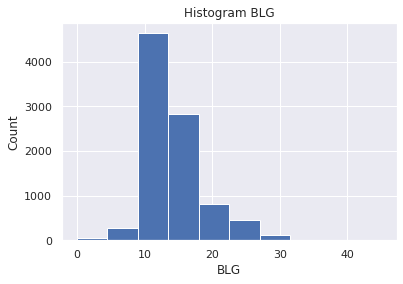

In [22]:
plt.ylabel('Count')
plt.xlabel('BLG')
plt.title('Histogram BLG')
beers.blg.hist()

Czyszczenie kolumny alko

In [23]:
beers.alko.unique()

array([' alk. 4.8', ' alk. 5.0', ' alk. 7.0', ' 27.5', ' alk. 10.5',
       ' alk. 6.7', ' alk. 4.6', ' alk. 4.5', ' alk. 11.0', ' alk. 6.4',
       ' alk. 5.2', ' alk. 6.5', ' alk. 6.6', ' alk. 5.1', ' alk. 4.3',
       ' alk. 6.3', ' alk. 3.5', ' alk. 9.2', ' alk. 4.1', ' alk. 4.9',
       ' alk. 8.0', ' alk. 7.5', ' alk. 5.8', ' alk. 7.4', ' alk. 12.0',
       ' alk. 9.0', ' alk. 5.9', ' alk. 13.0', ' alk. 6.2', ' alk. 8.5',
       ' alk. 7.7', ' alk. 6.0', ' alk. 7.9', ' alk. 4.7', ' alk. 5.5',
       ' alk. 6.9', ' alk. 11.5', ' alk. 4.0', ' alk. 7.2', ' alk. 3.6',
       ' alk. 5.7', ' alk. 9.7', ' alk. 10.0', ' alk. 3.1', ' alk. 7.8',
       nan, ' alk. 8.3', ' alk. 5.6', ' alk. 9.3', ' alk. 2.4',
       ' alk. 0.0', ' alk. 5.3', ' alk. 9.1', ' alk. 4.2', ' alk. 6.1',
       ' alk. 9.4', ' alk. 10.4', ' alk. 5.4', ' alk. 2.6', ' alk. 3.2',
       ' alk. 3.8', ' alk. 1.0', ' alk. 2.0', ' alk. 4.4', ' alk. 3.9',
       ' alk. 7.6', ' alk. 8.7', ' alk. 10.1', ' alk. 10.8', ' alk. 3

In [24]:
#sprawdzenie IBU
beers[(beers.alko.str.contains('IBU') == True) & (beers.alko != beers.ibu)]

,alko,blg,data_dod,file_urls,files,ibu,kod,kraj,name,opis,type,user,fav,nfav,ocena,price


In [0]:
#usuniecie IBU
beers.alko[(beers.alko.str.contains('IBU') == True)]=np.nan

#dodatkowe czyscczenie
beers.alko = beers.alko.str.replace('alk. ', '').replace('brak', '').replace('alko', '').replace('\x1a', '').str.strip()

#numeric
beers.alko = pd.to_numeric(beers.alko)

(array([4.000e+01, 3.270e+02, 4.820e+02, 3.414e+03, 4.649e+03, 2.271e+03,
        9.950e+02, 6.700e+02, 4.140e+02, 4.060e+02, 2.140e+02, 1.330e+02,
        5.100e+01, 3.400e+01, 4.500e+01, 7.000e+00, 2.000e+00, 2.000e+00]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 20, 40,
        60, 80]),
 <a list of 18 Patch objects>)

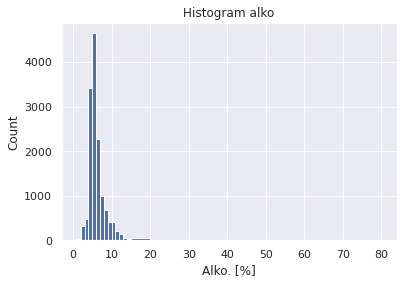

In [26]:
#Rozkład alko - rzut okiem, szczegółowe analizy później:
plt.ylabel('Count')
plt.xlabel('Alko. [%]')
plt.title('Histogram alko')
plt.hist(beers.alko, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,60,80])

Czyszczenie kolumny IBU

In [27]:
beers.ibu.unique()

array([nan, 'IBU 19', 'IBU 22', 'IBU 26', 'IBU 30', 'IBU 35', 'IBU 4',
       'IBU 5', 'IBU 60', 'IBU 85', 'IBU 96', 'IBU 75', 'IBU 50',
       'IBU 45', 'IBU 10', 'IBU 28', 'IBU 15', 'IBU 40', 'IBU 20',
       'IBU 25', 'IBU 197', 'IBU 68', 'IBU 29', 'IBU 2', 'IBU ok. 35',
       'IBU 38', 'IBU 32', 'IBU 36', 'IBU 8', 'IBU 46', 'IBU 100',
       'IBU b.d.', 'IBU 12%', 'IBU 18-22', 'IBU 43', 'IBU 65', 'IBU 18',
       'IBU 7', 'IBU 14', 'IBU 23', 'IBU 6', 'IBU 13', 'IBU 17', 'IBU 58',
       'IBU 27', 'IBU 108', 'IBU 125', 'IBU 52', 'IBU 33', 'IBU 24',
       'IBU 70', 'IBU 44', 'IBU 37', 'IBU 21', 'IBU 69', 'IBU 31',
       'IBU 11', 'IBU 47', 'IBU 111', 'IBU 12', 'IBU 16', 'IBU 51',
       'IBU 42', 'IBU 55', 'IBU 3', 'IBU 41', 'IBU 62', 'IBU 48',
       'IBU 80', 'IBU 72', 'IBU 353', 'IBU 93', 'IBU 102', 'IBU 34',
       'IBU 105', 'IBU 54', 'IBU 61', 'IBU 57', 'IBU 49', 'IBU 74',
       'IBU 127', 'IBU 53', 'IBU 99', 'IBU 1', 'IBU 90', 'IBU 63',
       'IBU 56', 'IBU 71', 'IBU 120'

In [0]:
#czysczenie
beers.ibu = beers.ibu.str.replace('IBU ', '').str.strip()
beers.ibu = beers.ibu.str.replace('IBU ', '').replace('ibu', '').replace('12%', '12').replace('18-22', '20').replace('b.d','').replace('brak','').replace('b.d.','').str.strip()
beers['ibu'][beers.ibu=='3/10']=30
beers['ibu'][beers.ibu=='ok. 35']=35

(array([ 73., 508., 803., 724., 548., 325., 330., 202., 100.,  44.,  74.,
         20.,  16.,   2.,   0.,   5.,   0.,   0.,   0.,   1.,   5.,   3.,
          0.,   0.,   1.,   0.,   0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 300, 400, 500, 600, 700,
        800, 900]),
 <a list of 27 Patch objects>)

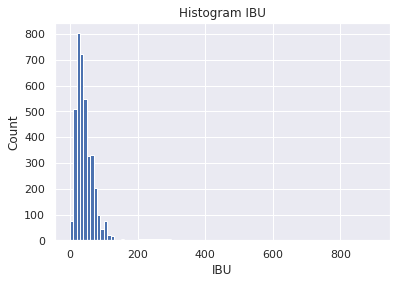

In [29]:
#Rozkład IBU - rzut okiem, szczegółowe analizy później:

beers.ibu = pd.to_numeric(beers.ibu)

plt.ylabel('Count')
plt.xlabel('IBU')
plt.title('Histogram IBU')
plt.hist(beers.ibu, np.concatenate((np.arange(0,200, 10),np.arange(200,1000, 100)), axis=None) )

In [0]:
#Data dodania - zmiana na numeic
beers.data_dod = beers.data_dod.str.replace('- ', '').str.strip()
beers.data_dod = pd.to_datetime(beers.data_dod)

In [31]:
#Kraj - część błędów zmieniam ręcznie

beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('polsk')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('Zamecky')), 'kraj'] = 'Czechy'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('Doctor Brew')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('Bialcz')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('Polsk')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('Stara')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('warski')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='producent') & (beers.name.str.contains('Piwo')), 'kraj'] = 'Polska'
beers.loc[(beers.kraj=='polska'), 'kraj'] = 'Polska'

print((beers.kraj.value_counts()/len(beers))[:5])

#Reszta ustawiona jako Polska, najbardzij liczna grupa
beers.loc[(beers.kraj=='producent'), 'kraj'] = 'Polska'


Polska             0.573782
Niemcy             0.073002
Czechy             0.040534
Wielka Brytania    0.038026
Belgia             0.029418
Name: kraj, dtype: float64


In [0]:
#fav column - liczba uzytkownikow, ktorzy oznaczyli dane piwo jako ulubione
beers.fav.fillna(0, inplace=True)
beers.fav = pd.to_numeric(beers.fav)

#nfav - liczba ludzi ktorzy ocenili piwo
beers.nfav = pd.to_numeric(beers.nfav)

In [0]:
#rating column
#sprawdzam czy jest możliwość że brak oceny, ale niezerowa liczba oceniających
beers[(beers.ocena == '0') & (beers.nfav != 0)]
beers.ocena = pd.to_numeric(beers.ocena.str.replace(',', '.'))

Kolumna cena - sprawdzam wszystko do złotówek

In [34]:
#unikaty
beers.price.unique()

array([nan, '4,50 zl', '3,50  ', '3,29  ', '1,80  ', '4,99 zl', '4,59  ',
       '24.99 zl', '3,00  ', '1,70  ', '8,50 zl', '3,99 zl', '14 zl',
       '10.40', '2,90 zl ', '4,00 zl', '4,49 zl', '6,50 zl', '6,99 zl',
       '1,50  ', '3,49 zl', '3,50 zl', '3,29 zl', '5,99 zl', '20 zl',
       '3,80 zl', '9,30 zl', '3,30 zl', '7,80 zl', '4,80 zl', '7,30 zl',
       '38', '2,49 zl', '8,00 zl', '10,00 zl', '12,00 zl', '11,00 zl',
       '16,00 zl', '3,00 zl', '2,50  ', '2,99 zl', '7,99 zl', '1,65  ',
       '1,99 zl', '1,15  ', '7,00 zl', '1,19  ', '2,50 zl', '6,10 zl',
       '4,19 zl', '1,79 zl', '7,90zl', '5,00 zl', '6 zl', '5,20 zl',
       '6,00 zl', '7,30 zl / 0,33l', '5,80 zl', '5,60 zl', '4 zl',
       '5,49 zl', '2,75  ', '3,19 zl', '2,99  ', '1,85  ',
       '9,99 zl (330 ml)', '4,50  ', '1,30  ', '6,5zl', '8,5zl', '2,40  ',
       '6,0 zl', '1,39  ', '7,0 zl', '2,79 zl', '0,95  ', '1,69zl',
       '15 zl', '0,99  ', '1,49  ', '8,30 zl', '7,5 zl', '7,60zl',
       '2,00  ', '8,30

In [0]:
beers['price'] = beers['price'].str.replace(',', '.')
beers['price'] = beers['price'].str.replace(r'\s*za.*', '', regex=True)
beers['price'] = beers['price'].str.replace(r'\s*/.*', '', regex=True)
beers['price'] = beers['price'].str.replace(' zl', '')
beers['price'] = beers['price'].str.replace('zl', '')
beers['price'] = beers['price'].str.replace('(330ml)', '')
beers['price'] = beers['price'].str.replace('(330 ml)', '')
beers['price'] = beers['price'].str.replace(' ()', '')
beers['price'] = beers['price'].str.replace('\(\)', '')
beers['price'] = beers['price'].str.replace('od23', '23')
beers['price'] = beers['price'].str.replace('Miedzy10a15', '12.5')
beers['price'] = beers['price'].str.replace('1.25Euro', '5,7') #1E=4.56
#w pozniejszych analizach okazlo sie ze podczas scrapingu znaki waluty zostaly usuniete
#wiec ta dana jest bezuzyteczna dla piw innych niz polskie

#jesli cena podana jako zakres to zmiana na srednia
prices = beers[beers['price'].str.contains('-')==True].price.str.split('-').apply(lambda x: (float(x[0]) + float(x[1]))/2)
beers.iloc[prices.index, 15] = prices.values

beers['price'] = beers['price'].str.replace(',', '.')
beers['price'] = pd.to_numeric(beers['price'])

In [36]:
#wyciecie nazwy obrazka, bo te tez pobrane

beers.drop(['file_urls'], axis=1, inplace=True) #kolumna niepotrzeban

beers.loc[1, ['files'] ].values #obrazek jest zaszyty w polu 'path' jsona

array(["[{'url': 'https://ocen-piwo.pl/upload/b3b9797d8e6e11df7cf81148416aff49.png', 'path': 'full/c6044a61d315dd1beff8d3c219bac5d42e841655.png', 'checksum': 'db6a281c25cbdd4d98b3c52c23a04acd'}]"],
      dtype=object)

In [0]:
beers.files = beers.files.str.extract(pat = 'full\/(.*?)\'')

### Dołożenie danych BJCP

W tabeli *beers* zawarte jest 2972 unikalnych typów piw, podczas gdy Beer Judge 
Certification Program wyróżnia 118 styli piw. W związku z tym dokonam 
zrutowania tych styli na BJCP.

BJCP określa również parametry jakimi powinny charakteryzować się poszczególne gatunki piw. Dlatego też w danych BJCP mamy takie parametry jak:


*   *OG - Orginal Gravity* - czyli potoczne BLG, stężenie ekstraktu w brzeczce przed fermentacją, tzw. brzeczki nastawnej, to co jest w *beers['blg']*, tylko że wyrażone zamiast w stopniach Plato, to w tzw. gęstości względnej (*specific gravity, SG*), przeliczalnej $ P =135.997  OG^3−630.272OG^2+1111.14OG−616.868$.
*   *FG - Final Gravity* - gęstość brzeczki po zakończonej fermentacji. Tego parametru zwykle nie spotyka się na etykietach.
*  *SRM - Standard Reference Method* - zapis określający kolor piwa:
 * Straw 2-3
 * Yellow 3-4 
 * Gold 5-6 
 * Amber 6-9
 * Deep amber/light copper 10-14
 * Copper 14-17
 * Deep copper/light brown 17-18
 * Brown 19-22
 * Dark Brown 22-30
 * Very Dark Brown 30-35
 * Black 30+
 * Black, opaque 40+
* *ABV  - Alcohol By Volume* - ilość alkoholu w jednostce objętości, w teori to samo co w *beers['alko']*




In [38]:
bjcp['styles'] = bjcp['styles'].str.lower()
bjcp.styles.unique()

array(['american light lager', 'american lager', 'cream ale',
       'american wheat beer', 'international pale lager',
       'international amber lager', 'international dark lager',
       'czech pale lager', 'czech premium pale lager',
       'czech amber lager', 'czech dark lager', 'munich helles',
       'festbier', 'helles bock', 'german leichtbier', 'kölsch',
       'german helles exportbier', 'german pils', 'märzen', 'rauchbier',
       'dunkles bock', 'vienna lager', 'altbier', 'pale kellerbier',
       'amber kellerbier', 'munich dunkel', 'schwarzbier', 'doppelbock',
       'eisbock', 'baltic porter', 'weissbier', 'dunkles weissbier',
       'weizenbock', 'ordinary bitter', 'best bitter', 'strong bitter',
       'british golden ale', 'australian sparkling ale', 'english ipa',
       'dark mild', 'british brown ale', 'english porter',
       'scottish light', 'scottish heavy', 'scottish export',
       'irish red ale', 'irish stout', 'irish extra stout', 'sweet stout',
       

Teraz dokonam ręcznej "normalizacji" typów piw podawanych przez użytkowników i/lub producentów. Dowolność jest dość duża i sprowadzę je do styli zdefniniowanych przez BJCP

In [0]:
#nowa kolumna
beers['styles_clean'] = beers['type'].str.lower().replace('india pale ale', 'ipa')
beers["bjcp"] = ''

#recczne przypisanie stylu bjcp do istniejacyego typu
#english ipa
beers['bjcp'][ (beers.styles_clean.str.contains('ipa')==True) & (beers.styles_clean.str.contains('english')==True)] = 'english ipa'
#british strong ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) & (beers.styles_clean.str.contains('english')==True) & (beers.styles_clean.str.contains('strong')==True) ] = 'british strong ale'
#belgian dark strong ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('strong')==True) &(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('dark')==True) & (beers['bjcp']=='' )]='belgian dark strong ale'
#belgian golden strong ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('strong')==True) &(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('golden')==True) & (beers['bjcp']=='' )]='belgian golden strong ale'
#belgian pale ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('pale')==True) & (beers['bjcp']=='' )]='belgian pale ale'
#belgian blond ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('blond')==True) & (beers['bjcp']=='' )]='belgian blond ale'
#belgian strong ale -> zmiana na belgian dark strong ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('strong')==True) & (beers['bjcp']=='' )]='belgian dark strong ale'
#belgian ale -> zmiana na belgian dark strong ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('belgian')==True) & (beers['bjcp']=='' )]='belgian dark strong ale'
#belgian dubbel
beers['bjcp'][(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('dubbel')==True) & (beers['bjcp']=='' )]='belgian dubbel'
#belgian tripel
beers['bjcp'][(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('tripel')==True) & (beers['bjcp']=='' )]='belgian tripel'
#belgian ipa => belgian pale ale
beers['bjcp'][(beers.styles_clean.str.contains('belgian')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='belgian pale ale'
#altbier
beers['bjcp'][(beers.styles_clean.str.contains('altbier')==True) & (beers['bjcp']=='' )]='altbier'
#weizenbock
beers['bjcp'][(beers.styles_clean.str.contains('weizenbock')==True) & (beers['bjcp']=='' )]='weizenbock'
#imperial stout
beers['bjcp'][(beers.styles_clean.str.contains('stout')==True) & (beers.styles_clean.str.contains('imperial')==True) & (beers['bjcp']=='' )]='imperial stout'
#lambic
beers['bjcp'][(beers.styles_clean.str.contains('lambic')==True) & (beers['bjcp']=='' )]='lambic'
#baltic porter
beers['bjcp'][(beers.styles_clean.str.contains('baltic')==True) & (beers['bjcp']=='' )]='baltic porter'
#american ipa
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='american ipa'
#american lager & light lager
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='american lager'
#american pale ale
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('pale')==True)& (beers.styles_clean.str.contains('ale')==True) & (beers['bjcp']=='' )]='american pale ale'
#american stout
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='american stout'
#american porter
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('porter')==True) & (beers['bjcp']=='' )]='american porter'
#american strong ale
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('strong')==True) & (beers['bjcp']=='' )]='american strong ale'
#grodziskie
beers['bjcp'][(beers.styles_clean.str.contains('grodziskie')==True)& (beers['bjcp']=='' )]='piwo grodziskie'
#american amber
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('amber')==True)& (beers['bjcp']=='' )]='american amber ale'
#american brown
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('brown')==True)& (beers['bjcp']=='' )]='american brown ale'
#american barleywine
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('barleywine')==True)& (beers['bjcp']=='' )]='american barleywine'
#american wheat beer
beers['bjcp'][(beers.styles_clean.str.contains('american')==True)& (beers.styles_clean.str.contains('wheat')==True)& (beers['bjcp']=='' )]='american wheat beer'
#czech premimu lager
beers['bjcp'][(beers.styles_clean.str.contains('czech')==True) &(beers.styles_clean.str.contains('lager')==True) &(beers.styles_clean.str.contains('premium')==True) & (beers['bjcp']=='' )]='czech premium pale lager'
#czech lager
beers['bjcp'][(beers.styles_clean.str.contains('czech')==True) &(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='czech pale lager'
#international lager
beers['bjcp'][(beers.styles_clean.str.contains('international')==True) &(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='international pale lager'
#vienna lager
beers['bjcp'][(beers.styles_clean.str.contains('vienna')==True) &(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='vienna lager'
#international dark lager
beers['bjcp'][(beers.styles_clean.str.contains('dark')==True) &(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='international dark lager'
beers['bjcp'][(beers.styles_clean.str.contains('dunkel')==True) &(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='international dark lager'
#international amber lager
beers['bjcp'][(beers.styles_clean.str.contains('amber')==True) &(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='international amber lager'
#international pale lager
beers['bjcp'][(beers.styles_clean.str.contains('lager')==True) & (beers['bjcp']=='' )]='international pale lager'
#weissbier
beers['bjcp'][(beers.styles_clean.str.contains('weissbier')==True) & (beers['bjcp']=='' )]='weissbier'
#german pils
beers['bjcp'][(beers.styles_clean.str.contains('pils')==True) & (beers['bjcp']=='' )]='german pils'
#spice
beers['bjcp'][(beers.styles_clean.str.contains('spice')==True) & (beers['bjcp']=='' )]='fruit and spice beer'
#weizenbock
beers['bjcp'][(beers.styles_clean.str.contains('weizen')==True) & (beers['bjcp']=='' )]='weizenbock'
#english porter
beers['bjcp'][(beers.styles_clean.str.contains('porter')==True) & (beers['bjcp']=='' )]='english porter'
#tropical stout
beers['bjcp'][(beers.styles_clean.str.contains('tropical')==True) &(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='tropical stout'
#sweet stout
beers['bjcp'][(beers.styles_clean.str.contains('sweet')==True) &(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='sweet stout'
#oatmeal stout
beers['bjcp'][(beers.styles_clean.str.contains('oatmeal')==True) &(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='oatmeal stout'
#irish stout
beers['bjcp'][(beers.styles_clean.str.contains('irish')==True) &(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='irish stout'
#foreign stout
beers['bjcp'][(beers.styles_clean.str.contains('foreign')==True) &(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='foreign extra stout'
#sweet stout
beers['bjcp'][(beers.styles_clean.str.contains('')==True) &(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='sweet stout'
#irish stout
beers['bjcp'][(beers.styles_clean.str.contains('stout')==True) & (beers['bjcp']=='' )]='irish stout'
#gose
beers['bjcp'][(beers.styles_clean.str.contains('gose')==True) & (beers['bjcp']=='' )]='gose'
#munich helles
beers['bjcp'][(beers.styles_clean.str.contains('helles')==True) & (beers.styles_clean.str.contains('munich')==True) & (beers['bjcp']=='' )]='munich helles'
#bock helles
beers['bjcp'][(beers.styles_clean.str.contains('helles')==True) & (beers.styles_clean.str.contains('bock')==True) & (beers['bjcp']=='' )]='helles bock'
#german helles
beers['bjcp'][(beers.styles_clean.str.contains('helles')==True) & (beers['bjcp']=='' )]='german helles exportbier'
#doppelbock
beers['bjcp'][(beers.styles_clean.str.contains('doppelbock')==True) & (beers['bjcp']=='' )]='doppelbock'
#dunkles
beers['bjcp'][(beers.styles_clean.str.contains('dunk')==True) &(beers.styles_clean.str.contains('bock')==True) & (beers['bjcp']=='' )]='dunkles bock'
#eisbock
beers['bjcp'][(beers.styles_clean.str.contains('eis')==True) &(beers.styles_clean.str.contains('bock')==True) & (beers['bjcp']=='' )]='eisbock'
#bock
beers['bjcp'][(beers.styles_clean.str.contains('bock')==True) & (beers['bjcp']=='' )]='helles bock'
#munich dunkel
beers['bjcp'][(beers.styles_clean.str.contains('munich')==True) & (beers['bjcp']=='' )]='munich dunkel'
#double ipa
beers['bjcp'][(beers.styles_clean.str.contains('double')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='double ipa'
#black ipa
beers['bjcp'][(beers.styles_clean.str.contains('black')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='black ipa'
#brown ipa
beers['bjcp'][(beers.styles_clean.str.contains('brown')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='brown ipa'
#red ipa
beers['bjcp'][(beers.styles_clean.str.contains('red')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='red ipa'
#rye ipa
beers['bjcp'][(beers.styles_clean.str.contains('black')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='rye ipa'
#white ipa
beers['bjcp'][(beers.styles_clean.str.contains('white')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='white ipa'
#english
beers['bjcp'][(beers.styles_clean.str.contains('england')==True) &(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='english ipa'
#saison
beers['bjcp'][(beers.styles_clean.str.contains('saison')==True) & (beers['bjcp']=='' )]='saison'
beers['bjcp'][(beers.styles_clean.str.contains('season')==True) & (beers['bjcp']=='' )]='saison'
#english ipa
beers['bjcp'][(beers.styles_clean.str.contains('ipa')==True) & (beers['bjcp']=='' )]='english ipa'
#english ipa
beers['bjcp'][(beers.styles_clean.str.contains('pale')==True) & (beers['bjcp']=='' )]='english ipa'
#fruit beer
beers['bjcp'][(beers.styles_clean.str.contains('beer')==True) &(beers.styles_clean.str.contains('fruit')==True) & (beers['bjcp']=='' )]='fruit beer'
#grain
beers['bjcp'][(beers.styles_clean.str.contains('grain')==True) & (beers['bjcp']=='' )]='alternative grain beer'
#keller
beers['bjcp'][(beers.styles_clean.str.contains('keller')==True) & (beers['bjcp']=='' )]='amber kellerbier'
#australian sparkling
beers['bjcp'][(beers.styles_clean.str.contains('austral')==True) & (beers['bjcp']=='' )]='australian sparkling ale'
#berliner
beers['bjcp'][(beers.styles_clean.str.contains('berlin')==True) & (beers['bjcp']=='' )]='berliner weisse'
#best
beers['bjcp'][(beers.styles_clean.str.contains('best')==True) & (beers['bjcp']=='' )]='best bitter'
#garde
beers['bjcp'][(beers.styles_clean.str.contains('garde')==True) & (beers['bjcp']=='' )]='biere de garde'
#blond ale
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('blond')==True) & (beers['bjcp']=='' )]='blond ale'
#brett
beers['bjcp'][(beers.styles_clean.str.contains('brett')==True) & (beers['bjcp']=='' )]='brett beer'
#california common
beers['bjcp'][(beers.styles_clean.str.contains('californ')==True) & (beers['bjcp']=='' )]='california common'
#cream
beers['bjcp'][(beers.styles_clean.str.contains('cream')==True) & (beers['bjcp']=='' )]='cream'
#mild
beers['bjcp'][(beers.styles_clean.str.contains('mild')==True) & (beers['bjcp']=='' )]='dark mild'
#eng barley
beers['bjcp'][(beers.styles_clean.str.contains('barley')==True) & (beers.styles_clean.str.contains('english')==True) & (beers['bjcp']=='' )]='english barleywine'
#american barley
beers['bjcp'][(beers.styles_clean.str.contains('barley')==True) & (beers.styles_clean.str.contains('americ')==True) & (beers['bjcp']=='' )]='american barleywine'
#american barley bourbon
beers['bjcp'][(beers.styles_clean.str.contains('barley')==True) & (beers.styles_clean.str.contains('bourbon')==True) & (beers['bjcp']=='' )]='american barleywine'
#pozostałe barley -> english
beers['bjcp'][(beers.styles_clean.str.contains('barley')==True) & (beers['bjcp']=='' )]='english barleywine'
#marzen i fest
beers['bjcp'][(beers.styles_clean.str.contains('marzen')==True) &(beers.styles_clean.str.contains('fest')==True) & (beers['bjcp']=='' )]='festbier'
#pozostałe marzen i fest
beers['bjcp'][(beers.styles_clean.str.contains('dortmu')==True) & (beers['bjcp']=='' )]='german helles exportbier'
#radler
beers['bjcp'][(beers.styles_clean.str.contains('radler')==True) & (beers['bjcp']=='' )]='radler'
#golden
beers['bjcp'][(beers.styles_clean.str.contains('ale')==True) &(beers.styles_clean.str.contains('gold')==True) & (beers['bjcp']=='' )]='british golden ale'
#sour
beers['bjcp'][(beers.styles_clean.str.contains('sour')==True)  & (beers['bjcp']=='' )]='mixed-fermentation sour beer'
#best bitter
beers['bjcp'][(beers.styles_clean.str.contains('bitter')==True)  & (beers.styles_clean.str.contains('extra')==True)  & (beers['bjcp']=='' )]='best bitter'
beers['bjcp'][(beers.styles_clean.str.contains('bitter')==True)  & (beers.styles_clean.str.contains('premium')==True)  & (beers['bjcp']=='' )]='best bitter'
beers['bjcp'][(beers.styles_clean.str.contains('bitter')==True)  & (beers.styles_clean.str.contains('special')==True)  & (beers['bjcp']=='' )]='best bitter'
beers['bjcp'][(beers.styles_clean.str.contains('bitter')==True)  & (beers.styles_clean.str.contains('best')==True)  & (beers['bjcp']=='' )]='best bitter'
#schwarzbier
beers['bjcp'][(beers.styles_clean.str.contains('schwarzbier')==True)  & (beers['bjcp']=='' )]='schwarzbier'
#strong bitter
beers['bjcp'][(beers.styles_clean.str.contains('bitter')==True)  & (beers.styles_clean.str.contains('strong')==True)  & (beers['bjcp']=='' )]='strong bitter'
#ordinary bitter
beers['bjcp'][(beers.styles_clean.str.contains('bitter')==True)  & (beers['bjcp']=='' )]='ordinary bitter'
#irish red
beers['bjcp'][(beers.styles_clean.str.contains('red')==True)  &(beers.styles_clean.str.contains('irish')==True)  & (beers['bjcp']=='' )]='irish red ale'
#amber ale
beers['bjcp'][(beers.styles_clean.str.contains('amber')==True)  &(beers.styles_clean.str.contains('ale')==True)  & (beers['bjcp']=='' )]='american amber ale'
#old ale
beers['bjcp'][(beers.styles_clean.str.contains('old')==True)  &(beers.styles_clean.str.contains('ale')==True)  & (beers['bjcp']=='' )]='old ale'
#tmav
beers['bjcp'][(beers.styles_clean.str.contains('tmav')==True) & (beers['bjcp']=='' )]='czech amber lager'
#zwickle
beers['bjcp'][(beers.styles_clean.str.contains('zwick')==True) & (beers['bjcp']=='' )]='pale kellerbier'
#quadrup
beers['bjcp'][(beers.styles_clean.str.contains('quadrup')==True) & (beers['bjcp']=='' )]='belgian dark strong ale'
#tripel
beers['bjcp'][(beers.styles_clean.str.contains('tripel')==True) & (beers['bjcp']=='' )]='belgian tripel'
#fruit pozostale
beers['bjcp'][(beers.styles_clean.str.contains('fruit')==True) & (beers['bjcp']=='' )]='fruit beer'
#speciality
beers['bjcp'][(beers.styles_clean.str.contains('special')==True) & (beers['bjcp']=='' )]='wild speciality beer'
#witbier
beers['bjcp'][(beers.styles_clean.str.contains('witbier')==True) & (beers['bjcp']=='' )]='witbier'

In [40]:
#ile bez klasyfikacji BJCP
print(len(beers[beers['bjcp']=='']))
beers.type[beers['bjcp']=='' ].groupby(beers.type.str.lower()).count().sort_values(ascending=False)

1330


type
::dodaj do filtra    217
summer ale            37
brown ale             26
wheat ale             26
kolsch                24
                    ... 
piwo anyzowe           1
plum roggenbier        1
podkoziolek            1
polciemne              1
 cesky lezak           1
Name: type, Length: 573, dtype: int64

In [41]:
#zlaczenie df beers z df bjcp, inner join wiec te bez klasyfikacji usuniete
beers.rename({'bjcp':'styles'}, axis='columns', inplace=True)

beers = pd.merge(beers, bjcp, on=['styles'], how='inner')
len(beers)

12735

In [0]:
#zmiana kolumn numerycznych
cols = ['abv min', 'abv max', 'ibus min', 'ibus max', 'srm min', 'srm max', 'og min', 'og max', 'fg min', 'fg max' ]
beers[cols] = beers[cols].apply(pd.to_numeric, errors='coerce', axis=1)

Zobaczmy jakie style są najliczniej reperzentowane:

In [43]:
print(beers.groupby('styles').count()['type'].sort_values(ascending = False)[:5])
print('\n')
print(beers.groupby('style family').count()['type'].sort_values(ascending = False)[:5])

styles
english ipa                 1950
international pale lager    1639
german pils                 1045
american pale ale            558
imperial stout               549
Name: type, dtype: int64


style family
IPA               2506
Pale Lager        2119
Wheat Beer        1418
Stout             1224
Specialty Beer    1113
Name: type, dtype: int64


Najwięcej brakujących wartości w numerycznych kolumnach, znajduje się w kolumnie price i IBU:

In [44]:
beers.isnull().sum()

alko                            150
blg                            4680
data_dod                          0
files                             0
ibu                            9463
kod                               0
kraj                              0
name                              0
opis                              0
type                              0
user                              0
fav                               0
nfav                              0
ocena                             0
price                         11283
styles_clean                      0
styles                            0
#                                 0
bjcp categories                   0
style family                      0
style history                     0
origin                            0
abv min                        1113
abv max                        1113
ibus min                       1113
ibus max                       1113
srm min                        1113
srm max                     

Sprawdam dla jakich styli brakuje teoretycznych wartości BJCP:




In [45]:
print(beers[beers['ibus min'].isnull()==True].groupby('styles').count()['type'])
print('\n')
print(beers[beers['ibus min'].isnull()==True].groupby('style family').count()['type'])

styles
alternative grain beer           26
brett beer                       24
fruit and spice beer            333
fruit beer                      430
mixed-fermentation sour beer    300
Name: type, dtype: int64


style family
Specialty Beer    1113
Name: type, dtype: int64


In [46]:
#missing mins and maxes are speciality beers - remove it
beers = beers[beers['ibus min'].isnull()==False].copy()
len(beers)

11622

### Uzupełnienie nulli w zakresie alkoholu, IBU i BLG w oparciu o dane z guidelines BJCP

Rozkład pustych wartości jest następujący:

In [47]:
beers[['ibu', 'alko', 'blg']].isnull().sum() * 100 / len(beers)

ibu     73.025297
alko     1.109964
blg     35.544657
dtype: float64

O ile w przypadku alkoholu pustych wartości jest niewiele (w Polsce istnieje prawny obowiązek podawania zawartości alkoholu na etykiecie), to w przypadku pozostałych jest zdecydowanie gorzej. O ile podstawowe działanie czyli usunięcie nulli w przypadku alkoholu nie zmieniłoby znacznie liczności, to w przypadku IBU spowodowałoby drastyczne ograniczenie ilości piw. W związku z tym trzeba te wartości uzupełnić. W tym celu skorzystam z dwóch metod:


1.   Uzupełnienie medianą dla danego stylu piwa
2.   Uzupełnienie MICE/Iterative imputation. 



In [0]:
#zachowanie oryginalnych wartosci
hist_values = beers[['alko', 'ibu', 'blg']]

#### Uzupełnienie medianą dla danego stylu piwa

In [0]:
#izastapienie nulli mediana danego stylu
beers['alko_med'] = beers.groupby("styles")['alko'].transform(lambda x: x.fillna(x.median()))

beers['ibu_med'] = beers.groupby("styles")['ibu'].transform(lambda x: x.fillna(x.median()))

beers['blg_med'] = beers.groupby("styles")['blg'].transform(lambda x: x.fillna(x.median()))

#### Uzupełninie MICE

Jako alternatywę dla mediany zastosuję *multivariate imputation by chained equations* nazwane jako MICE, przy czym wykonam tylko jeden przebieg:

In [0]:
#MICE
if calculate_everything:
  beers_mice_cat = beers[['type', 'styles', 'bjcp categories', 'style family', 'style history', 'origin']]
  beers_mice_numeric = beers[['alko', 'blg', 'ibu','abv min', 'abv max', 'ibus min', 'ibus max', 'srm min','srm max', 'og min', 'og max', 'fg min', 'fg max']]

  dummies = pd.get_dummies(beers_mice_cat)

  result = pd.concat([beers_mice_numeric , dummies.reindex(beers_mice_numeric.index)], axis=1)

  dfn = MICE(min_value=0, random_state=random_state ).fit_transform(result)

  pd.to_pickle(dfn, dump_path + 'mice_0.pkl' )
else:
  dfn=pd.read_pickle(dump_path + 'mice_0.pkl')
  imputed = pd.DataFrame(dfn)

In [0]:
imputed = imputed[[0,1,2]]
beers = pd.concat([beers , imputed.reindex(beers.index)], axis=1)
beers.rename(columns = {0:'alko_mice', 1:'blg_mice', 2:'ibu_mice'}, inplace=True)

In [52]:
#MICE zostawil 1090 pustych alko, blg and ibu:
print('Empty values after MICE: %d' % beers['ibu_mice'].isna().sum())

#w czesci pustych alko, blg i ibu, byly wartosci wiec je przywracam:
beers.loc[beers[(beers['ibu'].isna()==False) & (beers['ibu_mice'].isna())].index.values,'ibu_mice'] = beers.loc[beers[(beers['ibu'].isna()==False) & (beers['ibu_mice'].isna())].index.values,'ibu']
beers.loc[beers[(beers['alko'].isna()==False) & (beers['alko_mice'].isna())].index.values,'alko_mice'] = beers.loc[beers[(beers['alko'].isna()==False) & (beers['alko_mice'].isna())].index.values,'alko']
beers.loc[beers[(beers['blg'].isna()==False) & (beers['blg_mice'].isna())].index.values,'blg_mice'] = beers.loc[beers[(beers['blg'].isna()==False) & (beers['blg_mice'].isna())].index.values,'blg']

#pozostale 759 zastepuje mediana
beers.loc[beers[(beers['ibu_med'].isna()==False) & (beers['ibu_mice'].isna())].index.values,'ibu_mice'] = beers.loc[beers[(beers['ibu_med'].isna()==False) & (beers['ibu_mice'].isna())].index.values,'ibu_med']
beers.loc[beers[(beers['alko_med'].isna()==False) & (beers['alko_mice'].isna())].index.values,'alko_mice'] = beers.loc[beers[(beers['alko_med'].isna()==False) & (beers['alko_mice'].isna())].index.values,'alko_med']
beers.loc[beers[(beers['blg_med'].isna()==False) & (beers['blg_mice'].isna())].index.values,'blg_mice'] = beers.loc[beers[(beers['blg_med'].isna()==False) & (beers['blg_mice'].isna())].index.values,'blg_med']

#2 pozostale to Australian sparkling ale, ale to jedyni repreentanci tego stylu wiec wstawiam tam IBU z danych BJCP
beers.loc[beers[beers['styles'] == 'australian sparkling ale' ].index.values, ['ibu_mice', 'ibu_med']] = 27.5

print('Empty values: %d' % beers['ibu_mice'].isna().sum())

Empty values after MICE: 1047
Empty values: 0


#### Sprawdzenie i porównanie uzupełnień nulli

Nałożę na siebie rozkłady wartości przed uzupełnieniem i po uzupełnieniu w celu porównania wizualnego:

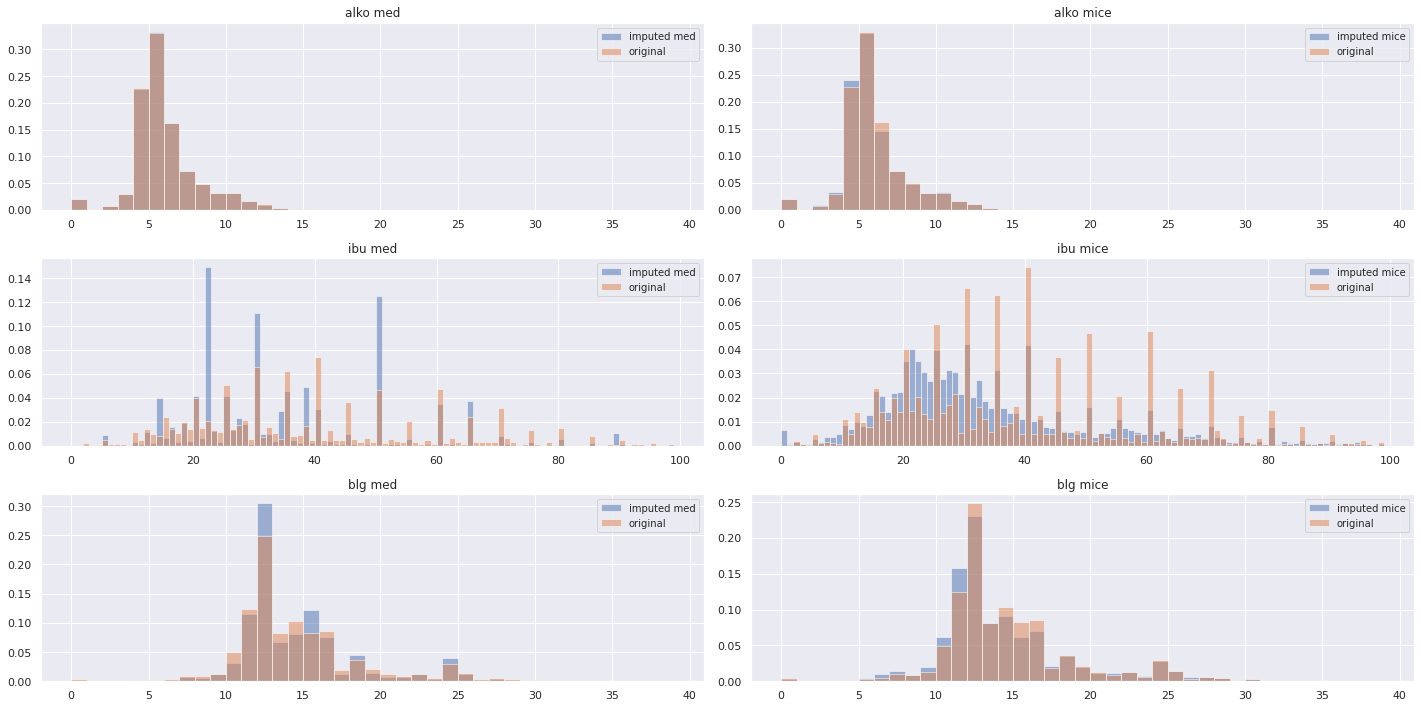

In [53]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
ax0, ax1, ax2, ax3, ax4, ax5  = axes.flatten()

#colors = ['red', 'tan', 'lime']
counts_alko_med = ax0.hist(beers.alko_med, np.arange(0, 40), alpha = 0.5, density=True, label='imputed med')
counts_alko = ax0.hist(beers.alko, np.arange(0,40), alpha = 0.5, density=True, label='original')
ax0.legend(prop={'size': 10})
ax0.set_title('alko med')

counts_alko_mice = ax1.hist(beers.alko_mice, np.arange(0,40), alpha = 0.5, density=True, label='imputed mice')
ax1.hist(beers.alko, np.arange(40), alpha = 0.5, density=True, label='original')
ax1.legend(prop={'size': 10})
ax1.set_title('alko mice')

counts_ibu_med = ax2.hist(beers.ibu_med, np.arange(0,100), alpha = 0.5, density=True, label='imputed med')
counts_ibu =ax2.hist(beers.ibu, np.arange(0,100), alpha = 0.5, density=True, label='original')
ax2.legend(prop={'size': 10})
ax2.set_title('ibu med')

counts_ibu_mice =ax3.hist(beers.ibu_mice, np.arange(0,100), alpha = 0.5, density=True, label='imputed mice')
ax3.hist(beers.ibu, np.arange(0,100), alpha = 0.5, density=True, label='original')
ax3.legend(prop={'size': 10})
ax3.set_title('ibu mice')

counts_blg_med = ax4.hist(beers.blg_med, np.arange(0,40), alpha = 0.5, density=True, label='imputed med')
counts_blg =ax4.hist(beers.blg, np.arange(0,40), alpha = 0.5, density=True, label='original')
ax4.legend(prop={'size': 10})
ax4.set_title('blg med')

counts_blg_mice =ax5.hist(beers.blg_mice, np.arange(0,40), alpha = 0.5, density=True, label='imputed mice')
ax5.hist(beers.blg, np.arange(0,40), alpha = 0.5, density=True, label='original')
ax5.legend(prop={'size': 10})
ax5.set_title('blg mice')

fig.tight_layout()
plt.show()

Następnie sprawdzam zgodność rozkładów testem $\chi^2$

In [54]:
"""Uwaga, testy na zakresach, jako ze miedzy koszykami wartosci sa puste koszyki,
a do testu potrzeba "ciaglych" zakresow
"""

def interpret(p, prob=0.95):
    alpha = 1.0 - prob

    if p <= alpha:
	      print('   Rejecting H0, two variables are NOT independent')
    else:
	      print('   Accepting H0, two variables are independent')

s, p = chisquare(100*counts_alko_med[0][0:18], 100*counts_alko[0][0:18])
print("Alkohol median: %0.3f" % p)
interpret(p)

s, p = chisquare(100*counts_alko_mice[0][0:18], 100*counts_alko[0][0:18])
print("Alkohol MICE: %0.3f" % p)
interpret(p)

print('\n')

s, p = chisquare(100*counts_ibu_med[0][1:83], 100*counts_ibu[0][1:83]) 
print("IBU median: %0.3f" % p)
interpret(p)

s, p = chisquare(100*counts_ibu_mice[0][1:83], 100*counts_ibu[0][1:83]) 
print("IBU MICE: %0.3f" % p)
interpret(p)

print('\n')

s, p = chisquare(100*counts_blg_med[0][14:-4], 100*counts_blg[0][14:-4])
print("BLG median: %0.3f" % p)
interpret(p)

s, p = chisquare(100*counts_blg_mice[0][14:-4], 100*counts_blg[0][14:-4])
print("BLG MICE: %0.3f" % p)
interpret(p)

Alkohol median: 1.000
   Accepting H0, two variables are independent
Alkohol MICE: 1.000
   Accepting H0, two variables are independent


IBU median: 0.000
   Rejecting H0, two variables are NOT independent
IBU MICE: 0.995
   Accepting H0, two variables are independent


BLG median: 1.000
   Accepting H0, two variables are independent
BLG MICE: 1.000
   Accepting H0, two variables are independent


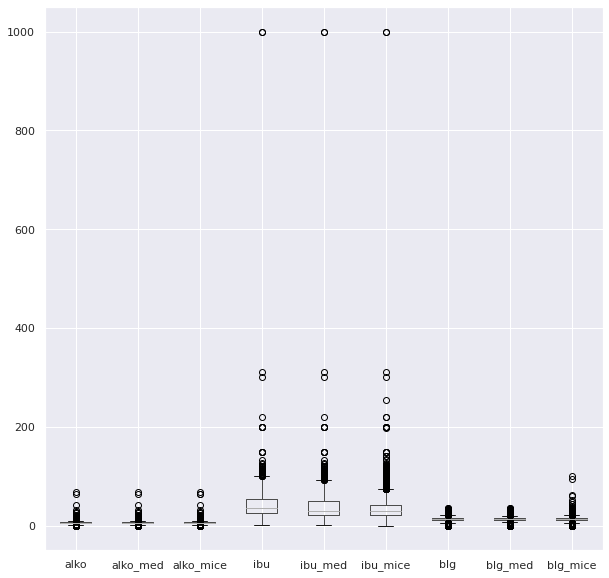

In [55]:
beers[['alko', 'alko_med','alko_mice', 'ibu', 'ibu_med','ibu_mice', 'blg', 'blg_med', 'blg_mice']].boxplot(figsize=(10,10))

W przypadku alkoholu i BLG, w których liczba nulli była <50%, średnia i odchylnie standardowe zmieniły się nieznacznie, w przypadku IBU zmiana jest większa.

Na podstawie wizualnej oceny, testów i zasady keep-it-simple, użyję w przypadku alkoholu i BLG danych uzupełnionych medianą, a w przypadku IBU, danych z MICE.

### Dołożenie danych o chmielach

In [56]:
hops.head(2)

,hop,type,country,alpha acid min,alpha acid max
0,Admiral,Bittering Hops,England,13.5,16
1,Agnus,Bittering Hops,Czech Republic,12.0,14


Niestety nie ma wprost danych o chmielach na stronie, z której pobrano dane. Ale w opisach piwach czasem są podane użyte chmiele, w związku z tym użyję po prostu regexów do znalezienia chmieli w opisach i jak są, to do wyciągnięcia ich.

In [57]:
matches = hops.hop.str.lower().values #tablica z chmielami z csv
safe_matches = [re.escape(m) for m in matches] #w celu załatwienia dziwnych znaczków
print(safe_matches)

# funkcja, która stworzy tablicę ze znalezionymi chmielami w opisie
def hops_matcher(description):
    hops=[]
    for hop in safe_matches:
        if hop in description:
            hops.append(hop)
    if not hops:
      return np.NaN
    else:
      return hops

['admiral', 'agnus', 'ahil', 'ahtanum', 'alliance', 'aalst', 'amallia', 'amarillo', 'amethyst', 'apollo', 'apolon', 'aquila', 'aramis', 'atlas', 'aurora', 'azacca', 'backa', 'banner', 'bate\\’s\\ brewer', 'bianca', 'bitter\\ gold', 'blato', 'blisk', 'blue\\ northern\\ brewer', 'boadicea', 'bobek', 'bor', 'bouclier', 'bramling', 'bramling\\ cross', 'bravo', "brewer\\'s\\ gold", 'brewer', 'buket', 'bullion', 'bullion', 'buzz\\ bullets', 'calicross', 'caliente', 'california\\ cluster', 'calypso', 'canadian\\ redvine', 'canterbury\\ whitebine', 'cascade', 'cashmere', 'cekin', 'celeia', 'centennial', 'cerera', 'challenger', 'chelan', 'chinook', 'cicero', 'citra', 'cluster', 'cobb', 'coigneau', 'columbia', 'columbus', 'comet', 'crystal', 'dana', 'defender', 'delta', 'density', 'dr\\ rudi', 'dunav', 'early\\ bird', 'early\\ green', 'early\\ prolific', 'early\\ promise', 'east\\ kent\\ golding', 'eastern\\ gold', 'eastern\\ green', 'eastwell\\ golding', 'el\\ dorado', 'ella', 'elsaesser', 'eni

In [0]:
#przeszukuje
beers['hops'] =  beers["opis"].apply(lambda x: hops_matcher(x))

In [59]:
print("Fraction of beers, with identified hops: %0.3f" % (len(beers[beers.hops.isna() == False])/len(beers)))

Fraction of beers, with identified hops: 0.105


### Finalne czyszczenie df beers

In [0]:
#RZastapienie danych BJCP srednimi z min i imax
beers['abv_mean'] = (beers['abv min'] + beers['abv max'] )/2
beers['abv_d'] = beers['abv max']- beers['abv_mean']
beers['ibus_mean'] = (beers['ibus min'] + beers['ibus max'] )/2
beers['ibus_d'] = beers['ibus max']- beers['ibus_mean']
beers['srm_mean'] = (beers['srm min'] + beers['srm max'] )/2
beers['smr_d'] = beers['srm max']- beers['srm_mean']
beers['og_mean'] = (beers['og min'] + beers['og max'] )/2
beers['og_d'] = beers['og max']- beers['og_mean']
beers['fg_mean'] = (beers['fg min'] + beers['fg max'] )/2
beers['fg_d'] = beers['fg max']- beers['fg_mean']

#Rusuniecie niepotrzebnych kolumn
beers.drop(['abv min','abv max','ibus min','ibus max','srm min','srm max',
            'og min','og max','fg min','fg max', 'kod', 'type', '#', 'alko_mice',
            'blg_mice', 'ibu_med' ], axis=1, inplace=True)

In [0]:
#zmiana nazw kolumn
for col in ['kraj', 'name', 'user', 'bjcp categories', 'style family', 'style history', 'origin']:
    beers[col] = beers[col].str.lower()

In [0]:
#zmienne kategorialne
beers["kraj"] = beers["kraj"].astype('category')
beers["styles"] = beers["styles"].astype('category')
beers["bjcp categories"] = beers["bjcp categories"].astype('category')
beers["style family"] = beers["style family"].astype('category')
beers["style history"] = beers["style history"].astype('category')
beers["origin"] = beers["origin"].astype('category')

In [63]:
beers.dtypes

alko                                 float64
blg                                  float64
data_dod                      datetime64[ns]
files                                 object
ibu                                  float64
kraj                                category
name                                  object
opis                                  object
user                                  object
fav                                    int64
nfav                                   int64
ocena                                float64
price                                float64
styles_clean                          object
styles                              category
bjcp categories                     category
style family                        category
style history                       category
origin                              category
overall impression                    object
aroma                                 object
appearance                            object
flavor    

In [0]:
#usuniecie 'starych' kolumn i zostawienie imputowanych
beers.drop(['alko', 'blg', 'ibu'], axis=1, inplace=True)
beers.rename(columns = {'alko_med':'alko', 'blg_med':'blg', 'ibu_mice':'ibu'}, inplace=True)

In [65]:
beers.describe()

,fav,nfav,ocena,price,alko,blg,ibu,abv_mean,abv_d,ibus_mean,ibus_d,srm_mean,smr_d,og_mean,og_d,fg_mean,fg_d
count,11622.000000,11622.000000,11622.000000,1254.000000,11622.000000,11560.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000,11622.000000
mean,2.006367,27.222079,5.529824,7.031053,5.957318,14.296246,35.609097,5.986874,0.952938,34.098133,8.696653,11.607834,3.469347,1057.559026,8.083290,1012.970745,3.287214
std,8.002181,111.416287,3.011929,21.768391,2.302591,3.954279,24.126281,1.549504,0.526945,16.812015,4.975223,9.612216,2.001086,14.845704,5.017197,4.093746,1.383728
min,0.000000,0.000000,0.000000,0.390000,0.000000,0.000000,0.000000,2.900000,0.250000,5.000000,2.500000,2.500000,0.500000,1030.000000,1.500000,1004.500000,1.000000
25%,0.000000,1.000000,5.000000,2.790000,4.800000,12.000000,22.000000,5.000000,0.650000,21.500000,5.000000,4.000000,2.000000,1047.000000,4.000000,1010.000000,2.000000
50%,0.000000,3.000000,6.720000,4.495000,5.500000,13.000000,30.000000,5.300000,0.850000,30.000000,9.000000,10.000000,3.500000,1052.000000,7.000000,1012.000000,3.000000
75%,1.000000,14.000000,7.550000,7.537500,6.500000,15.500000,42.513689,6.250000,1.250000,50.000000,10.000000,13.500000,4.375000,1062.500000,12.500000,1014.000000,4.000000
max,188.000000,2795.000000,10.000000,500.000000,67.500000,36.600000,1000.000000,11.500000,3.000000,90.000000,30.000000,35.000000,9.500000,1100.000000,21.000000,1027.500000,7.500000


Zrzucam oczyszczoną ramkę do pickla. 

In [0]:
beers.to_pickle(dump_path + 'beers_final.pkl')

## Czyszczenie i przygotowanie ramki z komentarzami

In [67]:
#komentarze uzytkownikow
comments = pd.read_csv(data_path + "koment_all2.csv", sep=',', engine='python')
comments.head(3)

,koment,name,user
0,"2019-12-17 12:12:15 Wodniste, ciekawy smak sus...",Gloger Podpiwek Trzy Sliwki,marcin729
1,2019-12-23 18:00:02 Ciemne bordo. Piana slaba....,Polczyn Kozlak,Gandalfino
2,2019-12-18 01:14:55 Piwo juz jest w katalogu j...,Polczyn Kozlak,nietzsche


In [68]:
#brak nulli
comments.isnull().sum()

koment    0
name      0
user      0
dtype: int64

In [69]:
#usuniecie duplikatow
print('Number of comments: %d' % len(comments))
comments.drop_duplicates(inplace=True)
print('Number of comments after duplicates removal: %d' % len(comments))

Number of comments: 26436
Number of comments after duplicates removal: 24568


In [0]:
#wyciecie daty i czasu z tresci komentarza
comments['date'] = pd.to_datetime(comments.koment.str[:20].replace('- ', '').str.strip())
comments.koment = comments.koment.str[20:].str.strip()

In [71]:
#w niektorych komentarzach sa oceny.:
print(comments.koment[0])

Wodniste, ciekawy smak suszonych sliwek. Sam podpiwek przecietny. Oceny uzytkownika: 5 ( smak: 5, zapach: 6, wyglad: 5 )


In [72]:
#funkcja do wyciecia ratingu i umieszczenia w nowych kolumnach
def get_ratings(coment):
  if coment.find("Oceny uzytkownika:")+18 >17:
    koment = coment[:coment.find("Oceny uzytkownika:")]
    rating = (coment[coment.find("Oceny uzytkownika:")+18:coment.find("Oceny uzytkownika:")+21])
    taste = (coment[coment.find("( smak: ")+8:coment.find("( smak: ")+11])
    smell = (coment[coment.find(", zapach: ")+10:coment.find(", zapach: ")+13])
    appearance = (coment[coment.find(", wyglad: ")+9:coment.find(", wyglad: ")+12])

    return koment, rating.replace(',', '').strip(),taste.replace(',', '').strip(),smell.replace(',', '').strip(), appearance.replace(',', '').strip()
  else:
    return coment, np.NaN,np.NaN,np.NaN,np.NaN
    
comments['koment'], comments['rating'], comments['taste'], comments['smell'], comments['appearance'] = zip(*comments['koment'].apply(get_ratings))

#numeric
comments['rating'] = pd.to_numeric(comments['rating'])
comments['taste'] = pd.to_numeric(comments['taste'])
comments['smell'] = pd.to_numeric(comments['smell'])
comments['appearance'] = pd.to_numeric(comments['appearance'])


comments.head(4)

,koment,name,user,date,rating,taste,smell,appearance
0,"Wodniste, ciekawy smak suszonych sliwek. Sam p...",Gloger Podpiwek Trzy Sliwki,marcin729,2019-12-17 12:12:15,5.0,5.0,6.0,5.0
1,Ciemne bordo. Piana slaba. W aromacie karmel i...,Polczyn Kozlak,Gandalfino,2019-12-23 18:00:02,7.0,6.0,9.0,6.0
2,Piwo juz jest w katalogu jako Polczynskie Bock...,Polczyn Kozlak,nietzsche,2019-12-18 01:14:55,NaN,NaN,NaN,NaN
3,Ciezko powiedziec czy te piwa sa tozsame. Brow...,Polczyn Kozlak,Piwosz92,2019-12-18 07:58:07,NaN,NaN,NaN,NaN


In [73]:
#% of bez ratingow
100*comments.isnull().sum()/len(comments)

koment         0.000000
name           0.000000
user           0.000000
date           0.000000
rating        29.432595
taste         29.432595
smell         29.432595
appearance    29.432595
dtype: float64

In [74]:
comments[:-5].describe()

,rating,taste,smell,appearance
count,17335.000000,17335.000000,17335.000000,17335.000000
mean,6.561869,6.493856,6.510816,6.758119
std,1.743759,1.867281,1.849378,1.661897
min,1.000000,1.000000,1.000000,1.000000
25%,6.000000,5.000000,5.000000,6.000000
50%,7.000000,7.000000,7.000000,7.000000
75%,8.000000,8.000000,8.000000,8.000000
max,10.000000,10.000000,10.000000,10.000000


Rozkład ocen:

In [75]:
comments.rating.value_counts().sort_index()

1.0      159
2.0      288
3.0      604
4.0      960
5.0     2037
6.0     3456
7.0     4558
8.0     3365
9.0     1470
10.0     440
Name: rating, dtype: int64

Text(0.5, 1.0, 'Ratings histogram')

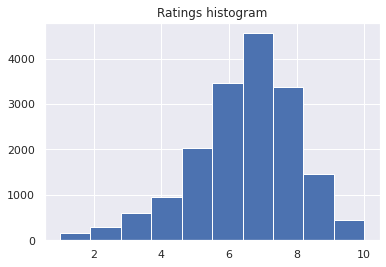

In [76]:
comments.rating.hist()
plt.title('Ratings histogram')

In [0]:
comments['user'] = comments['user'].astype('str')
comments['name'] = comments['name'].astype('str')

#na male litery
comments.user = comments.user.str.lower()
comments.name = comments.name.str.lower()



In [78]:
#Dane o piwach i komentarzach byly scrapowane osobno z roznica kilku dni
#wiec sa komentarze do piw ktore nie istnieja w ramce beers

print('Comments count: %d' % len(comments))

comments= pd.merge(comments, beers.name, how='inner', left_on=['name'],
                   right_on=['name'])

print('Comments count after removal of some beers: %d' % len(comments))

Comments count: 24568
Comments count after removal of some beers: 19147


In [0]:
#koduje nazyw piw i nazwy uzytkownikow do crossreferencji
le_user = LabelEncoder()
le_beer = LabelEncoder()

beers['label_name'] = le_beer.fit_transform(beers['name'])
comments['label_name'] = le_beer.transform(comments['name'])

le_user.fit(comments.user.append(beers.user).unique())

beers['label_user'] = le_user.transform(beers['user'])
comments['label_user'] = le_user.transform(comments['user'])



In [80]:
#komentarze ocenione
comments_rated = comments[comments['rating'].isna()==False]
print('No of rated comments: %d' % len(comments_rated))


No of rated comments: 13388


Czy sa przypadki że użytkownik skomentowal ocenil piwo kilkukrotnie?


In [81]:
comments_rated.groupby(['name', 'user']).size().sort_values(ascending=False).head(3)

name                                   user        
breclav kanec 12                       nietzsche       5
stortebeker hanse-porter               nietzsche       4
kormoran imperium prunum esencja 2019  barcelonismo    4
dtype: int64

Zostawiam najnowszy komentarz jeśli była kilkukrotna ocena:

In [82]:
comments_rated['user'] = comments_rated['user'].apply(lambda x: str(x))
comments_rated['name'] = comments_rated['name'].apply(lambda x: str(x))


comments_rated.sort_values(['user', 'name', 'date'], ascending=True, inplace=True)
comments_rated.drop_duplicates(subset=['user','name'], keep="last", inplace=True)

print('No of rated comments after deduplication: %d' % len(comments_rated))

comments_rated.groupby(['user','name']).size().sort_values(ascending=False).head(3)

No of rated comments after deduplication: 12934


user         name                         
zomer        tiger beer                       1
gregoriss33  krynica kult pszeniczne jasne    1
grubyperez   doctor brew dixie apa            1
dtype: int64

# Eksploracja danych

In [83]:
beers.head(3)

,data_dod,files,kraj,name,opis,user,fav,nfav,ocena,price,styles_clean,styles,bjcp categories,style family,style history,origin,overall impression,aroma,appearance,flavor,mouthfell,comments,history,characteristic ingredients,style comparison,commercial examples,notes,alko,blg,ibu,hops,abv_mean,abv_d,ibus_mean,ibus_d,srm_mean,smr_d,og_mean,og_d,fg_mean,fg_d,label_name,label_user
0,2019-11-29 12:01:52,b2da5775a3f4c3624d10137805ac1fe89c81b009.png,polska,dwie wieze malinowa beka,Uwarzone przez Browar Dwie Wieze. Piwo belgijs...,barcelonismo,0,0,0.0,NaN,sour belgian raspberry ale,belgian dark strong ale,trappist ale,strong ale,belgian strong ale,belgium,"A dark, complex, very strong Belgian ale with ...","Complex, with a rich-sweet malty presence, sig...",Deep amber to deep coppery-brown in color (dar...,"Similar to aroma (same malt, ester, phenol, al...",High carbonation but not sharp. Smooth but not...,Authentic Trappist versions tend to be drier (...,Most versions are unique in character reflecti...,Belgian yeast strains prone to production of h...,"Like a larger dubbel, with a fuller body and i...","Achel Extra Brune, Boulevard The Sixth Glass, ...",NaN,4.8,12.0,0.000000,NaN,10.0,2.0,27.5,7.5,17.0,5.0,1092.5,17.5,1017.0,7.0,3040,64
1,2019-11-17 09:13:06,fc6df6afb4ddad1684195d28f70cc2de45bada76.png,belgia,de dolle oerbier,Piwo warzone przez Brouwerij De Dolle Brouwers...,nietzsche,0,0,0.0,NaN,belgian strong dark ale,belgian dark strong ale,trappist ale,strong ale,belgian strong ale,belgium,"A dark, complex, very strong Belgian ale with ...","Complex, with a rich-sweet malty presence, sig...",Deep amber to deep coppery-brown in color (dar...,"Similar to aroma (same malt, ester, phenol, al...",High carbonation but not sharp. Smooth but not...,Authentic Trappist versions tend to be drier (...,Most versions are unique in character reflecti...,Belgian yeast strains prone to production of h...,"Like a larger dubbel, with a fuller body and i...","Achel Extra Brune, Boulevard The Sixth Glass, ...",NaN,9.0,18.5,27.181619,[star],10.0,2.0,27.5,7.5,17.0,5.0,1092.5,17.5,1017.0,7.0,2567,579
2,2019-11-09 09:54:39,7321d01876cab5a8141825ade1f7f82f104f0e0b.png,belgia,leffe winter,"Leffe Winter to piwo o bursztynowej barwie, z ...",damcio88,0,0,0.0,NaN,belgian specialty ale,belgian dark strong ale,trappist ale,strong ale,belgian strong ale,belgium,"A dark, complex, very strong Belgian ale with ...","Complex, with a rich-sweet malty presence, sig...",Deep amber to deep coppery-brown in color (dar...,"Similar to aroma (same malt, ester, phenol, al...",High carbonation but not sharp. Smooth but not...,Authentic Trappist versions tend to be drier (...,Most versions are unique in character reflecti...,Belgian yeast strains prone to production of h...,"Like a larger dubbel, with a fuller body and i...","Achel Extra Brune, Boulevard The Sixth Glass, ...",NaN,6.6,18.5,22.281673,NaN,10.0,2.0,27.5,7.5,17.0,5.0,1092.5,17.5,1017.0,7.0,5818,146


## Analiza styli, kategorii, rodzin piw

Zobaczmy jakie są najpopularniejsze style, kategorie, rodziny piw w bazie (znormalizowane na podstawie BJCP):

In [84]:
for col in ['styles', 'bjcp categories', 'style family', 'style history', 'origin']:
  d = beers.groupby(col).count()['name'].sort_values(ascending=False)
  print(len(d))
  print(d[:5])
  print('\n')

63
styles
english ipa                 1950
international pale lager    1639
german pils                 1045
american pale ale            558
imperial stout               549
Name: name, dtype: int64


26
bjcp categories
pale commonwealth beer       2020
international lager          1825
pale bitter european beer    1158
german wheat beer             695
dark british beer             617
Name: name, dtype: int64


13
style family
ipa           2506
pale lager    2119
wheat beer    1418
stout         1224
pilsner       1050
Name: name, dtype: int64


25
style history
english pale ale          2077
mass market pale lager    1737
pilsner                   1107
english stout             1091
wheat beer                1061
Name: name, dtype: int64


11
origin
england          3755
germany          2849
international    1825
united states    1601
belgium          1017
Name: name, dtype: int64




Najczęściej występującym stylem jest English IPA, więc nie jest zaskoczeniem, że w pozostałych kategoriach na topie będą kategorie związane z tym stylem.

Przed przejściem do kolejnych kroków pozbędę się obserwacji odstających ($x \notin \mu \pm 3\sigma$) alkoholu, ibu i blg.

In [0]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

In [86]:
print(len(beers))
beers_out = beers[~beers.groupby('style family')['ibu'].apply(is_outlier)]
beers_out = beers_out[~beers_out.groupby('style family')['blg'].apply(is_outlier)]
beers_out = beers_out[~beers_out.groupby('style family')['alko'].apply(is_outlier)]
print(len(beers_out))

11622
10990


Zobaczmy jak rozkładają się poszczególne rodziny piw względem IBU i BLG

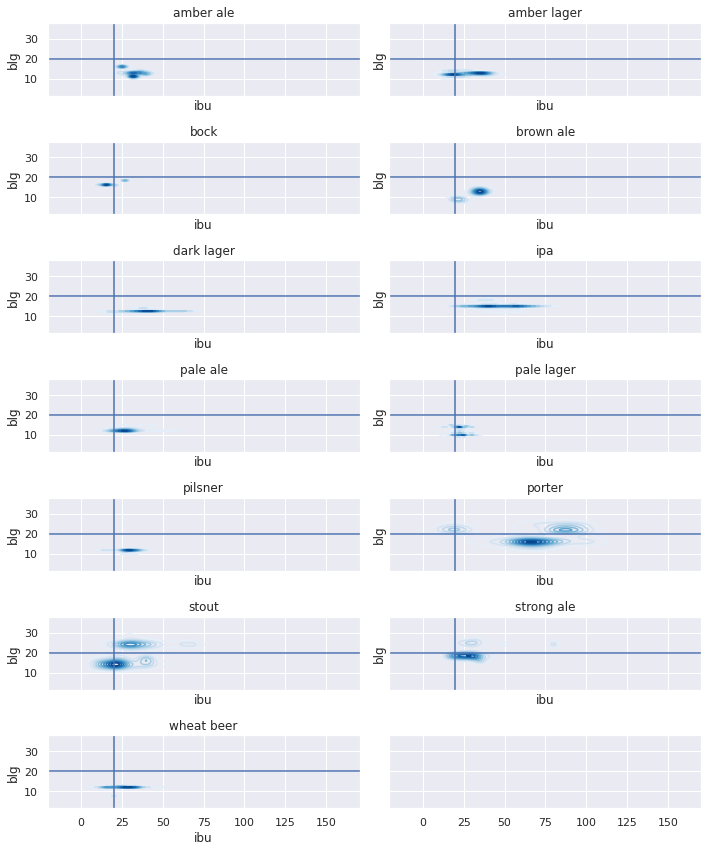

In [87]:
style_fam = beers_out['style family'].cat.categories.values

fig, axes = plt.subplots(ncols=2, nrows=7, figsize=(10,12), sharey=True, sharex=True)
sns.set_style("white")
for i, ax in zip(np.arange(13), axes.flat):
 
    k =sns.kdeplot(beers_out[beers_out['style family']==style_fam[i]]['ibu'],
            beers_out[beers_out['style family']==style_fam[i]]['blg'],
            cmap="Blues",
            shade_lowest=True, 
            ax=ax, 
            )
    a1 = fig.axes[i]
    a1.set_title(style_fam[i])

    k.axvline(20)
    k.axhline(20)

fig.tight_layout()
#plt.show()

Niektóre rodziny różnią się wizualnie znacząco tymi dwoma parametrami, np. Porter i Wheat Beer, inne jak IPA i Dark Lager, wyglądają bardzo podobnie.

Kolejne wykresy dodają jeszcze trzeci wymiar jakim jest zawartość alkoholu. Najpierw zobaczymy wszystkie razem, potem dla przykładu, wspomaniane wcześniej Porter i Wheat Beer oraz IPA i Dark Lager. 

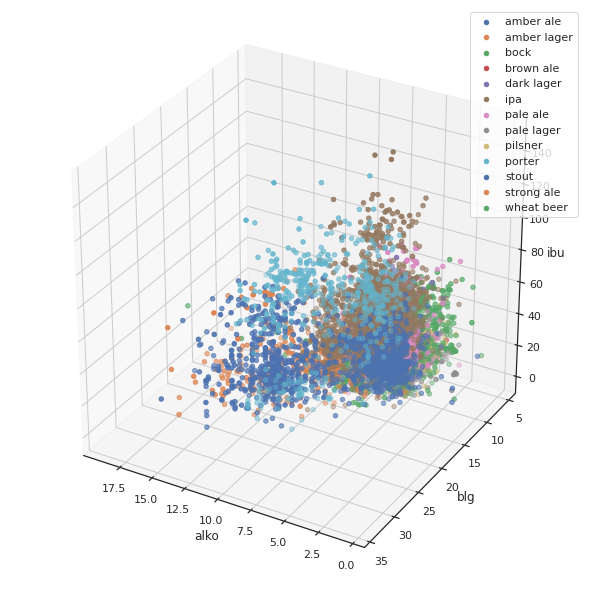

In [88]:
def plot_beer_3d(df, col, by):
  style_fam = by

  fig = plt.figure(figsize=(8,8))
  ax = Axes3D(fig)

  for sf in style_fam:  
      ax.scatter(beers_out[beers_out[col] == sf]['alko'], 
              beers_out[beers_out[col] == sf]['blg'], 
              beers_out[beers_out[col] == sf]['ibu'],
              label=sf)

  ax.set_xlabel('alko')
  ax.set_ylabel('blg')
  ax.set_zlabel('ibu')
  ax.view_init(30, 120)
  plt.legend()
  plt.show()

plot_beer_3d(beers_out, 'style family', beers_out['style family'].cat.categories.values)

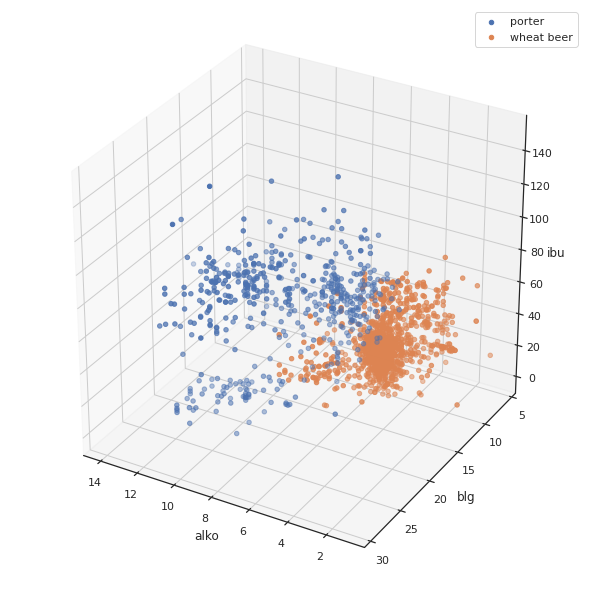

In [89]:
plot_beer_3d(beers_out, 'style family',['porter', 'wheat beer'])  

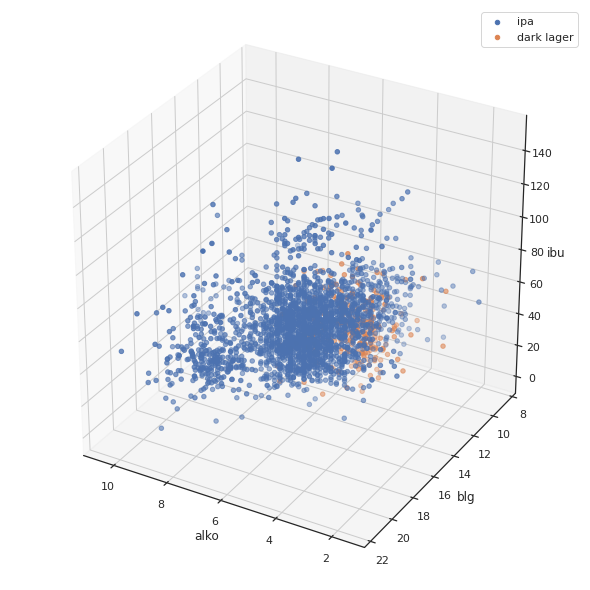

In [90]:
plot_beer_3d(beers_out, 'style family',['ipa', 'dark lager'])  

Gdyby nie kolory, raczej trudno *na oko* byłoby odróżnić style od siebie. W części Modelowanie, zobaczymy czy uda się zbudować klasyfikator, jak i łączyć piwa w klastry.







## Analiza alkoholu

In [91]:
beers_out['alko'].describe()

count    10990.000000
mean         5.993790
std          1.870067
min          0.500000
25%          4.900000
50%          5.500000
75%          6.500000
max         19.000000
Name: alko, dtype: float64

[]

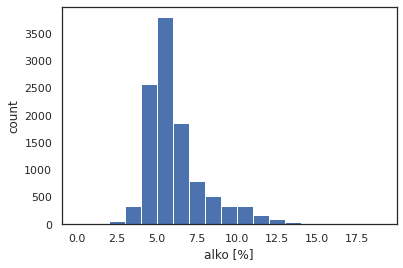

In [92]:
plt.hist(beers_out.alko, np.arange(0, 20))
plt.xlabel('alko [%]')
plt.ylabel('count')
plt.plot()

Widzymy, że przeciętne piwo ma 5.99% $\pm$ 1.86% zawrotści alkoholu.

Zobaczmy jak rozkłada się stężenie alkoholu względem styli.

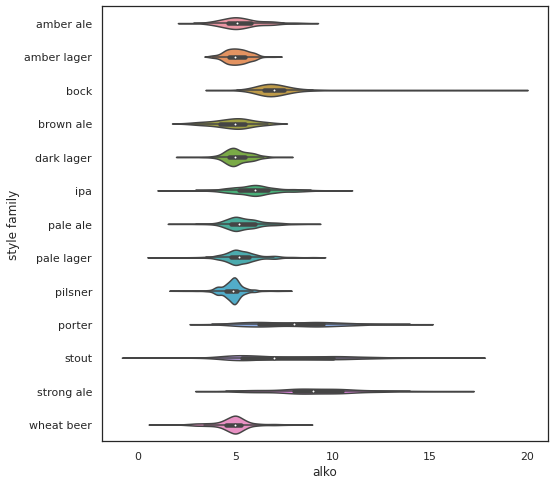

In [93]:
plt.figure(figsize=(8,8))
ax = sns.violinplot(x='alko', y='style family', data=beers_out )

Zobaczmy wartości, przy okazji dołożę od razu charakterystykę koloru:

In [94]:
a = beers_out[['alko', 'style family']].groupby(['style family']).agg({'alko':['mean','std']}).sort_values(by=('alko', 'mean'), ascending=False)
pd.merge(a, beers_out[['style family', 'srm_mean']].groupby(['style family']).mean(), how='inner', left_on=['style family'],
                   right_on=['style family'])

,"(alko, mean)","(alko, std)",srm_mean
style family,,,
strong ale,9.139608,2.201062,13.986765
porter,7.900385,2.019700,24.364162
stout,7.740992,2.753811,34.685988
bock,7.195455,1.581830,11.464015
ipa,6.070962,1.210097,10.000000
pale ale,5.422722,0.935700,8.568060
amber ale,5.321788,1.060456,12.533520
pale lager,5.320217,0.968366,4.162713
amber lager,5.093165,0.595279,12.214029


Najmocniejsze styl piwa, to Strong Ale, czego można było domyśleć się po nazwie. Na podium znalazły się również Porter i Stout.

Strong Ale to szeroka grupa piw. Za to Porter i Stout to dwa stare gatunki piw wywodzące się z Anglii. Oba są mocnymi i treściwymi piwami (sprawdzimy przy okazji analizy BLG i IBU). Porter swój ciemnych kolor zawdzięcza użyciu brązowych słodów, za to Stout często zawiera palone słody. Zdaniem niektórych Stout wywodzi się bezpośrednio od porteru (nazwa użyta pierwszy raz w 1721 roku, na określenie ciemnego piwa warzonego z palonego słodu). Najbardziej znane stouty to Guiness i Murphys. Szczególnymi przypadkami porterów są portery bałtyckie, które w odróżnieniu od angielskich są piwami dolnej fermentacji, których najstarszym polskim przedstawicielem jest Żywiec Porter ważony od 1881 r. w Cieszynie.

## Analiza BLG

Tak jak zostało to wspomniane na początku, BLG to stężenie ekstraktu w brzeczce przed fermentacją inaczej mówiąc, początkowa zawartość cukru w brzeczce piwnej i to jest podawane czasem na etykietach. Cukier w piwie bierze się z zacieru, kiedy naturalne cukry zawarte w słodzie (jęczmiennym, pszeniczny, owsianymm itd.) przechodzą do cieczy, która w wyniku kolejnych działań piwowarskich przekształci się w piwo.

Wyższy ekstrakt **niekoniecznie** oznacza, że piwo będzie słodsze. W brzeczce podstawowej oprócz cukrów nadających słodyczy znajdują się też cukry fermentowalne, które w wyniku pracy drożdży zamieniane są w alkohol i to one zwykle są w przewadze. O tym ile cukrów w piwie zostanie przefermentowane wynika z procesu zacierania (tzw. "zacieranie na słodko" lub "na wytrawnie") oraz od szczepu drożdży.

Znając poziom ekstraktu początkowego (OG), z etykiety i zawartość alkoholu,  można w przybliżeniu określić czy mamy do czynienia z piwem bardziej lub mniej słodkim. Piwo o stosunkowo niskiej zawartości alkoholu i wysokim ekstrakcie będzie pełniejsze (słodsze) od piwa o takiej samej zawartości alkoholu i niższym ekstrakcie. 

Ponownie polecam: http://mojkufelek.pl/piwny-elementarz-co-to-jest-ekstrakt-piwa.html

In [95]:
beers_out['blg'].describe()

count    10990.000000
mean        14.351374
std          3.771816
min          5.500000
25%         12.000000
50%         13.000000
75%         15.500000
max         34.000000
Name: blg, dtype: float64

[]

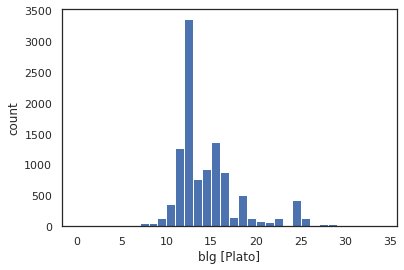

In [96]:
plt.hist(beers_out.blg, np.arange(0, 35))
plt.xlabel('blg [Plato]')
plt.ylabel('count')
plt.plot()

Widzymy, że przeciętne piwo ma 14.33 °Blg $\pm$ 3.76 °Blg ekstraktu.

Zobaczmy jak rozkłada się ekstrakt względem styli.

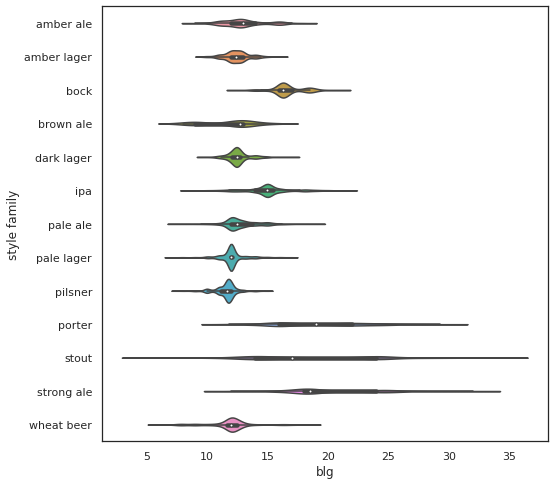

In [97]:
plt.figure(figsize=(8,8))
ax = sns.violinplot(x='blg', y='style family', data=beers_out )

In [98]:
a = beers_out[['blg', 'style family']].groupby(['style family']).agg({'blg':['mean','std']}).sort_values(by=('blg', 'mean'), ascending=False)
pd.merge(a, beers_out[['style family', 'srm_mean']].groupby(['style family']).mean(), how='inner', left_on=['style family'],
                   right_on=['style family'])

,"(blg, mean)","(blg, std)",srm_mean
style family,,,
strong ale,20.186176,3.908024,13.986765
porter,19.242967,3.941839,24.364162
stout,18.901668,5.222268,34.685988
bock,16.684848,1.331255,11.464015
ipa,15.003222,1.922236,10.000000
amber ale,13.072207,1.755105,12.533520
pale ale,12.865059,1.507008,8.568060
dark lager,12.602198,0.982491,20.135531
amber lager,12.453597,1.027266,12.214029


Ponownie TOP3 wygląda analogicznie jak w przypadku alkoholu. Nie jest to zaskakujące i można było się tego spodziewać, znając choćby jakościową zależność stężenia alkoholu od zawartości ekstraktu podstawowego.

## Analiza IBU

IBU (International Bitterness Units), czyli międzynarodową, jednostkę goryczy. Wartość IBU oblicza się przez obliczenie zawartości izo-$\alpha$-kwasów w próbce piwa. Izo-$\alpha$-kwasy to takie związki zawarte w chmielu powodujące, że piwo nabiera goryczy. 

Rzecz w tym, że z perspektywy pijącego IBU ma niewielkie znaczenie. Dzieje się tak dlatego, że z jednej strony uczucie goryczy jest sprawą indywidualną. Drugą kwestią jest zawartość ekstraktu, omówiona już wcześniej. Jedno piwo o wysokim IBU i danej wartości ekstraktu BLG będzie bardzo gorzkie, ale kiedy wartość IBU pozostanie niezmieniona, ale wartość ekstraktu będzie np. 2x większa, będzie już słodkie. Dlatego też wybieranie piwa na podstawie IBU nie ma większego sensu, ponieważ jest to tylko jeden z kilku czynników decydujących o poziomie goryczy w piwie. Jeśli już IBU jest podane na etykiecie, to napewno będzie też podana zawartość alkoholu i BLG, co pozwoli wnioskować o smaku. 

Jest to też przy okazji odpowiedź, czemu w analizowanym zbiorze była tak duża ilość pustych IBU. Parametr jest ten względnie rzadko podawany na etykiecie - pod względem smakowym ma niewielką wartość infomracyjną. 

In [99]:
beers_out['ibu'].describe()

count    10990.000000
mean        34.969409
std         19.122935
min          0.000000
25%         22.007081
50%         30.000000
75%         42.000000
max        150.000000
Name: ibu, dtype: float64

[]

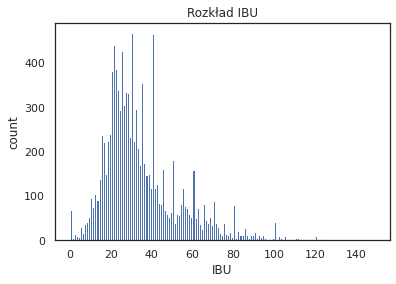

In [100]:
plt.hist(beers_out.ibu, np.arange(0, 150))
plt.xlabel('IBU')
plt.ylabel('count')
plt.title('Rozkład IBU')
plt.plot()

Widzymy, że przeciętne piwo ma 35 IBU $\pm$ 19 IBU - rozrzut jest bardzo duży.

Zobaczmy jak rozkłada się IBU względem styli.

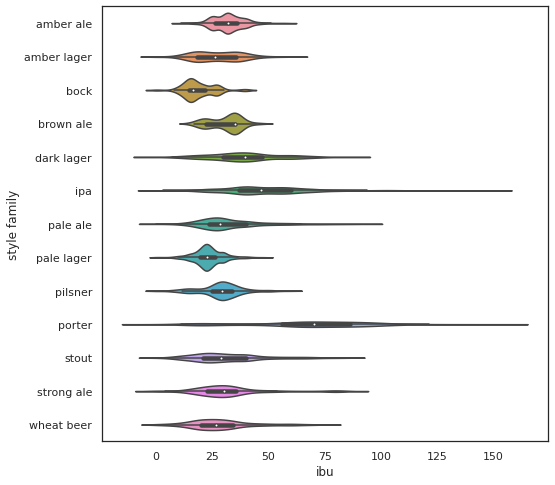

In [101]:
plt.figure(figsize=(8,8))
ax = sns.violinplot(x='ibu', y='style family', data=beers_out )

In [102]:
beers_out[['ibu', 'style family']].groupby(['style family']).agg({'ibu':['mean','std']}).sort_values(by=('ibu', 'mean'), ascending=False)

ibu           
                   mean        std
style family                      
porter        67.717363  26.620886
ipa           49.366165  19.339934
dark lager    39.021826  15.559857
pale ale      32.944180  15.014905
strong ale    31.958662  16.229343
amber ale     31.919264   7.078534
stout         31.761601  15.886500
brown ale     30.638889   6.887474
pilsner       28.491770   9.529237
wheat beer    28.360764  13.814288
amber lager   27.111289  10.765112
pale lager    23.021108   6.767933
bock          18.758323   7.128870

Ponownie Porter jest TOP3, tym razem na pierwszym miejscu. Jednak, tak jak zostało wspomniane - IBU, bez pozostałych charakterystyk nie wiele mówi o piwie. Jest to parametr chemiczny.

### Analiza korelacji między zmiennymi alko, BLG i IBU

Zweryfikuję teraz czy pomiędzy parametrami zachodzi jakaś korelacja. Intuicyjnie, powinna istnieć pozytywna korelacja między ekstraktem brzeczki (BLG), a ilością alkoholu, oraz nieistotna z IBU.

Zobaczymy również jak wyglądają dane teoretyczne BJCP.

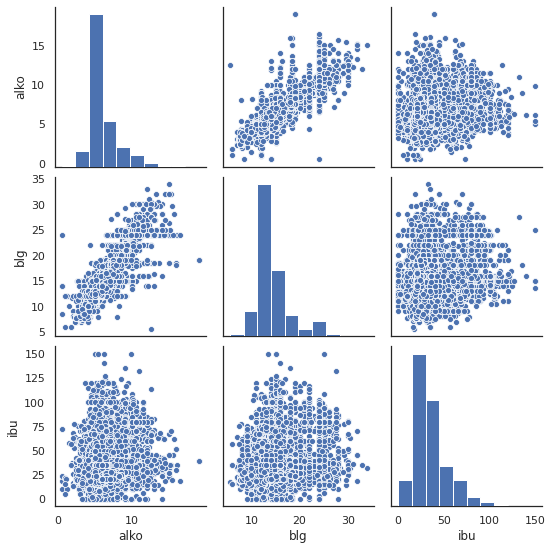

In [103]:
sns.pairplot(beers_out[['alko','blg', 'ibu']])

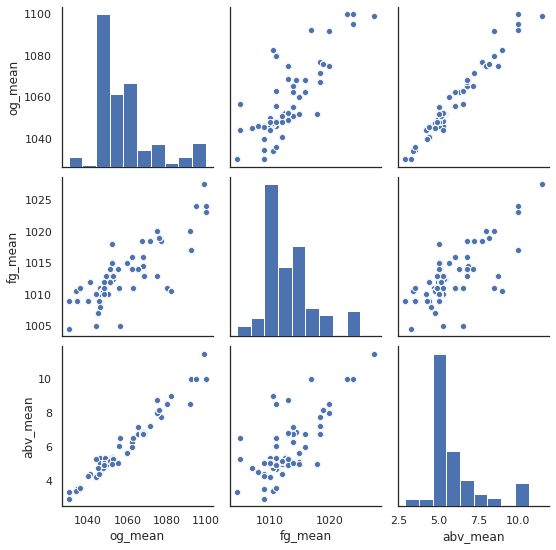

In [104]:
sns.pairplot(beers_out[['og_mean', 'fg_mean', 'abv_mean']])

Istotnie, istnieje silna zależność liniowa między stężeniem alkoholu, a ekstraktem brzeczki. Na danych teoretycznych BJCP widzimy również podobne charakterstyki.

Zobaczmy współczynniki korelacji:

In [105]:
cor = beers_out[['alko','blg', 'ibu', 'og_mean', 'fg_mean', 'abv_mean']].corr()
cor

,alko,blg,ibu,og_mean,fg_mean,abv_mean
alko,1.000000,0.870099,0.182477,0.735371,0.631130,0.749625
blg,0.870099,1.000000,0.258021,0.812759,0.752905,0.804028
ibu,0.182477,0.258021,1.000000,0.182166,0.145726,0.145908
og_mean,0.735371,0.812759,0.182166,1.000000,0.822718,0.978085
fg_mean,0.631130,0.752905,0.145726,0.822718,1.000000,0.755913
abv_mean,0.749625,0.804028,0.145908,0.978085,0.755913,1.000000


In [106]:
#najsilniejsze korelacje:
cor = cor.where(np.triu(np.ones(cor.shape, dtype=np.bool), k=1)).stack().sort_values()
cor[abs(cor)>0.5]

alko     fg_mean     0.631130
         og_mean     0.735371
         abv_mean    0.749625
blg      fg_mean     0.752905
fg_mean  abv_mean    0.755913
blg      abv_mean    0.804028
         og_mean     0.812759
og_mean  fg_mean     0.822718
alko     blg         0.870099
og_mean  abv_mean    0.978085
dtype: float64

Zależności są zgodne z przewidywaniami.

Uwaga: celowo nie brałem do analiz wartości SRM, czyli koloru piwa, które mimo, że mają wartość numeryczną, są w rzeczywistości zmiennymi kategorialnymi.

## Ceny piw

W trakcie analizy zorientowałem się, że w trakcie pobierania danych spiderem usunięciu uległy znaki kodujące walutę typu €, $, £, w związku z tym informacja o cenie, dla piw zagranicznych, jest zafałszowana i pomieszane złotówki z walutą.

W związku z tym ograniczę się tylko do analizy piw polskich.

In [107]:
pol = beers_out[(beers_out['kraj']== 'polska') & (beers_out['price'].isna()==False)]
pol['price'].describe()

count    619.000000
mean       5.987868
std        4.174197
min        1.200000
25%        2.990000
50%        5.200000
75%        7.900000
max       49.990000
Name: price, dtype: float64

[]

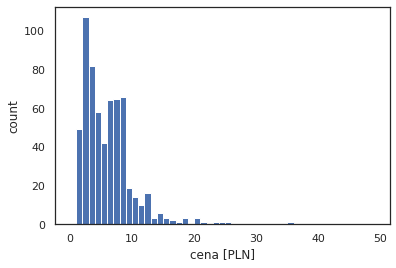

In [108]:
plt.hist(pol.price, np.arange(0, 50))
plt.xlabel('cena [PLN]')
plt.ylabel('count')
plt.plot()

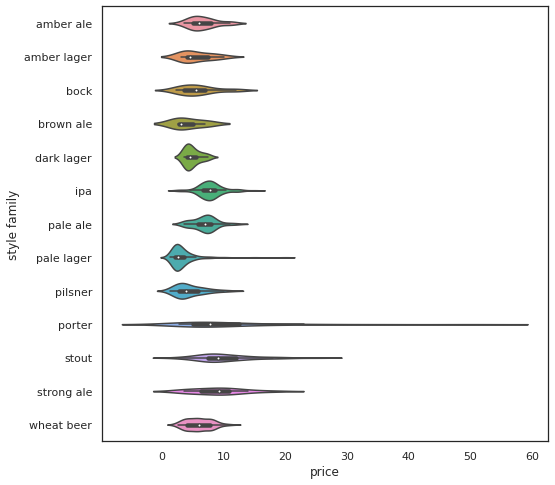

In [109]:
plt.figure(figsize=(8,8))
ax = sns.violinplot(x='price', y='style family', data=pol )

Zobaczmy najdroższe i najtańsze polskie piwa

In [110]:
print(pol[['name', 'price']].sort_values(by='price').head(3))
print('\n')
print(pol[['name', 'price']].sort_values(by='price').tail(3))



                      name  price
4887  amber browarne lager   1.20
7313       zodiak lew pils   1.29
4622        barley classic   1.29


                                            name  price
3199  doctor brew ris bourbon/brandy barrel aged  25.00
8233                              recraft mentor  35.00
8243                  ciechan porter wielkanocny  49.99


## Data dodania

Zobaczmy jak wygląda ilość dodanych piw po kwartałach:

[]

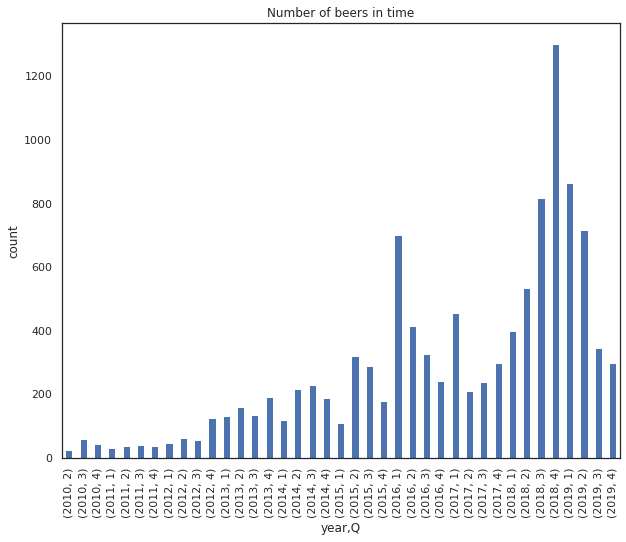

In [111]:
plt.figure(figsize=(10,8))

d = beers_out.groupby([beers_out.data_dod.dt.year.rename('year'), beers_out.data_dod.dt.quarter.rename('Q')]).size()

ax = d.plot.bar()

ax.set_xticks(range(len(d)))
ax.set_xticklabels(["%s-Q%01d" % item for item in d.index.tolist()], rotation=90)
ax.set_ylabel('count')
ax = d.plot.bar()

plt.title('Number of beers in time')

plt.plot()

I jak to wygląda kumulatywnie:

[]

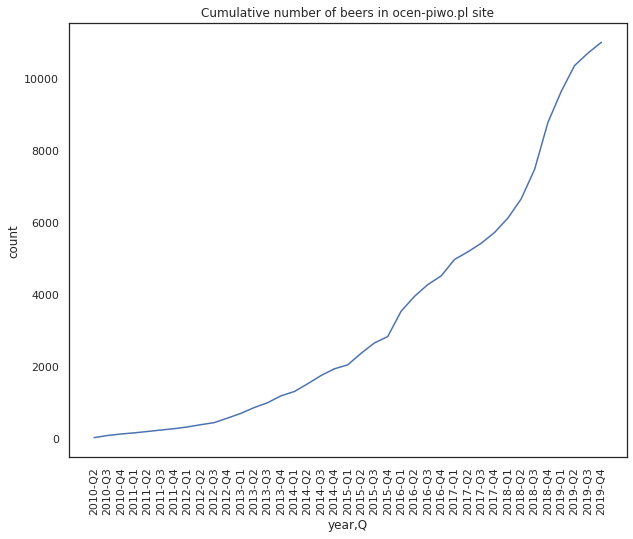

In [112]:
plt.figure(figsize=(10,8))

ax = d.cumsum().plot()
ax.set_xticks(range(len(d.cumsum())))
ax.set_xticklabels(["%s-Q%01d" % item for item in d.cumsum().index.tolist()], rotation=90)
ax.set_ylabel('count')

plt.title('Cumulative number of beers in ocen-piwo.pl site')

plt.plot()

Ewidentnie występuje tu trend i sezonowość, szereg jest niestacjonarany, ale nie będę się w tej analizie tym zajmować, jako, że nie wniesie to nic istotnego dla całej pracy.

## Kolory piw

Kolory piw są oznaczone wg standard reference method, opisanej już wcześniej. Klasyfikacja BJCP podawała minimalne i maksymalne zakresy kolorystyczne, które w ramach wstępnych przekształaceń zastąpiłem średnią.

Zobaczmy jak, wygląda rozkład kolorów:

[]

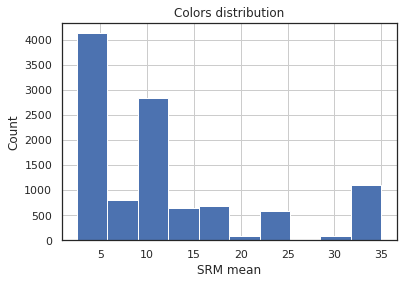

In [113]:
beers_out['srm_mean'].hist()
plt.title('Colors distribution')
plt.xlabel('SRM mean')
plt.ylabel('Count')
plt.plot()

Przekształcę wartości liczbowe na opisy:

In [0]:
bins = pd.IntervalIndex.from_tuples([(0, 3), (3, 4), (4, 6), (6,9), (9,14), (14,17),
                                     (17,18), (18, 22), (22,30), (30, 35), (35, 100)])

cut= pd.cut(beers_out['srm_mean'].to_list(), bins)

cut.categories=['straw', 'yellow', 'gold', 'amber', 'deep_amber', 'copper', 'deep_copper', 'brown', 
            'dark_brown','very_dark_brown', 'black']

beers_out['srm_mean']=cut

[]

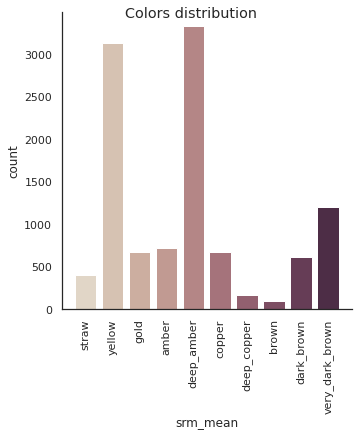

In [115]:
#beers_out['srm_mean'].value_counts()
ax = sns.catplot(x="srm_mean", kind="count", palette="ch:.25", data=beers_out,  )
ax.set_xticklabels(rotation=90)
ax.fig.suptitle('Colors distribution')
plt.plot()

Biorąc pod uwagę, że najczęściej występującym gatunkiem piwa jest IPA, to najwięszka liczność koloru deep amber nie zaskakuje.

## Najlepsze i najgorzsze piwa - ranking piw

Mając dane jakie analizujemy, spróbuję zrobić ranking najlepszych piw.

Każde piwo w ramce ma ocenę ('ocena') oraz liczbę użytkowników ('nfav'), który ocenili.

In [116]:
#Rating
beers_out[beers_out['ocena'] != 0]['ocena'].describe()

count    8800.000000
mean        6.951441
std         1.231073
min         1.000000
25%         6.220000
50%         7.000000
75%         7.770000
max        10.000000
Name: ocena, dtype: float64

In [117]:
#liczba ocen
beers_out[beers_out['ocena'] != 0]['nfav'].describe()

count    8800.000000
mean       34.936932
std       126.596596
min         1.000000
25%         2.000000
50%         6.000000
75%        20.000000
max      2795.000000
Name: nfav, dtype: float64

Średnia ocena piwa to ok. 7/10 i mediana oddanych głosów to 6. Spróbujemy znaleźć najlepsze piwo wg. ocen. Nie posłużę się po prostu samą ocenę, tylko wkalkuluję w to też ilość głosów. 

W tym celu posłużę się wzorem, który IMDB wykorzystuje do konstruowania swoich rankinków - https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#calculatetop , czyli:

$WR = (\frac{v}{v+m})  R + (\frac{m}{v+m}) C$

gdzie:

$R$ - ocena danego piwa,

$v$ - liczba oddanych głosów,

$m$ - minimalna liczba głosów, żeby być w rankingu, ustalę na medianę, czyli 6

$C$ - średnia ocena piw


In [0]:
br = beers_out[beers_out['nfav'] >=6]
mean = br['ocena'].mean()

br['WR'] = (br['nfav']/(br['nfav'] + 6))*br['ocena']+ (6/(br['nfav'] + 6))*mean

In [119]:
print('TOP5 best beers in ocen-piwo.pl beers:')
br.sort_values('WR', ascending = False)[['name','kraj', 'styles_clean', 'styles', 'ocena' ,'nfav', 'WR', 'opis', 'price']].head(5)


TOP5 best beers in ocen-piwo.pl beers:


,name,kraj,styles_clean,styles,ocena,nfav,WR,opis,price
8203,pinta imperator baltycki sherry oloroso barrel...,polska,baltic porter barrel aged,baltic porter,8.85,47,8.629316,"Do starzenia uzylismy 20 swiezo oproznionych, ...",23.0
133,westvleteren xii,belgia,belgian dark strong ale,belgian dark strong ale,9.36,14,8.622186,Piwo tworzone przez zakonnikow z opactwa Sw. S...,100.0
7503,doctor brew rodowite pils,polska,bohemian pilsener,german pils,9.36,14,8.622186,"Oficjalne piwo Lodzkiego Klubu Sportowego, war...",NaN
8150,czarna owca porter noster bourbon barrel aged,polska,baltic porter bourbon barrel aged,baltic porter,9.36,14,8.622186,Uwarzone przez Browar Czarna Owca. Kraft roku ...,NaN
751,trzech kumpli & pinta coast starlight,polska,seriously classic west coast ipa,english ipa,8.96,24,8.548124,Uwarzone w kooperacji przez Trzech Kumpli - Br...,NaN


In [120]:
print('TOP5 worst beers in ocen-piwo.pl site:')
br.sort_values('WR')[['name','kraj', 'styles_clean', 'styles', 'ocena' ,'nfav', 'WR', 'opis', 'price']].head(5)

TOP5 worst beers in ocen-piwo.pl site:


,name,kraj,styles_clean,styles,ocena,nfav,WR,opis,price
5375,coberg original premium beer,polska,pale lager,international pale lager,2.65,31,3.339290,Produkt Browaru Fuhrmann dla supermarketow Tes...,1.3
7104,kastel pils,polska,pils,german pils,2.47,19,3.533349,Wspanialy smak i aromat tego piwa mozna doceni...,NaN
5315,roger,polska,pale lager,international pale lager,3.34,99,3.543464,Dostepne w sieci sklepow Tesco. Aromat niemal ...,1.3
7022,burger premium pils,polska,premium pils,german pils,3.00,30,3.650104,"Piwo jasne, lekkie, warzone przez Zaklady Piwo...",NaN
5370,van pur barley gold 4.0 %,polska,pale lager,international pale lager,3.25,28,3.894227,Warzone przez Browar Van Pur. Najprawdopodobni...,NaN


Co do najlepszych piw, to cóż, trzeba spróbować i ocenić samemu. Jednocześnie warto zauważyć, że pierwsze miejsce jest zajęte przez gatunek piwa historycznie wywodzący się z pomorza.

Jeśli zaś chodzi o najgorsze piwa, to raczej zaskoczenia nie ma - obsadzone są przez podłe, budżetowe, lagery i pilsy, warzone dla supermarketów.

Sprawdźmy jeszcze czy istnieje jakaś korelacja między ceną a oceną piwa:

In [121]:
#total
print(br[br['kraj'] =='polska'][['price','WR']].corr())

#bardziej 'rozsadny' zakres cen:
print(br[(br['kraj'] =='polska') & (br['price'] < 20)][['price','WR']].corr())

          price        WR
price  1.000000  0.558572
WR     0.558572  1.000000
         price       WR
price  1.00000  0.58026
WR     0.58026  1.00000


Korealacja między ceną a oceną jest dodatnia umiarkowana.

### Oceny na podstawie komentarzy

Oceny piwa jak i smaku, zapachu i wyglądu, znajdują się również w komentarzach. Będąc przy ocenianiu piw, przenalizuję od razu te i porównam czy oceny wynikające z komentarzy są podobne do ocen ogólnych.

In [122]:
comments_rated.head(2)

,koment,name,user,date,rating,taste,smell,appearance,label_name,label_user
1450,Lekko gryzace nienachalne wysycenie. Aromat wi...,psotnik nocna zmiana,0xhiryuu,2019-07-21 01:13:56,9.0,9.0,9.0,9.0,8401,1
3085,"Taka woda ale ze spirytusem, mozna se w sumie ...",kent szlachetny jasne mocne,abiseth,2019-01-26 22:25:31,2.0,2.0,1.0,2.0,5009,4


In [123]:
#stworzmy ramke z ocenami
#jesli jest ocena to zawsze jest to trojka ocen
r = comments_rated.groupby('name').agg({'rating':['mean','count'], 'taste':['mean'], 'smell':['mean'],
                                    'appearance':['mean']})

r.head(2)

rating       taste smell appearance
                 mean count  mean  mean       mean
name                                              
 t ij columbus    8.0     1   8.0   8.0        7.0
 t ij ipa         7.0     1   7.0   7.0        7.0

In [0]:
#rating liczony jak poprzednio:

#mediana
median = r['rating']['count'].median() 

#mediana to tylko 2 komntarze - malo, wiec arbitralnie ustalam 4 komentarze
#daje to 1075 piw do oceny -> len(r[r['rating']['count'] >3])
cr = r[r['rating']['count'] >3]

def WR(col):
  mean = cr[col]['mean'].mean()  

  return (cr['rating']['count']/(cr['rating']['count'] + median))* \
  cr[col]['mean'] + (median/(cr['rating']['count'] + median))*mean

for col in ['rating', 'taste', 'smell', 'appearance']:
  cr[col + '_WR'] = WR(col)


In [125]:
#najelpsze
pd.merge(cr,beers_out, left_index=True, right_on=['name'],
         how='inner')[['name', 'kraj','styles_clean', 'styles', 
         ('rating', 'mean'), ('rating_WR', '')]].sort_values(('rating_WR', ''), 
                                                             ascending=False).head(3)

,name,kraj,styles_clean,styles,"(rating, mean)","(rating_WR, )"
10442,fortuna fortunatus i wild barley wine ba,polska,wild barley wine ba,english barleywine,9.50,8.602667
8713,hedgehog orange ipa,polska,american ipa,american ipa,9.25,8.436001
3190,golem lilith,polska,russian imperial stout,imperial stout,9.25,8.436001


In [126]:
#najlepsze w samaku
pd.merge(cr,beers_out, left_index=True, right_on=['name'],
         how='inner')[['name', 'kraj','styles_clean', 'styles', 
         ('taste', 'mean'), ('taste_WR', '')]].sort_values(('taste_WR', ''), 
                                                             ascending=False).head(3)

,name,kraj,styles_clean,styles,"(taste, mean)","(taste_WR, )"
11027,profesja kanclerz z malinami,polska,berliner weisse,berliner weisse,9.75,8.744621
8713,hedgehog orange ipa,polska,american ipa,american ipa,9.50,8.577955
10442,fortuna fortunatus i wild barley wine ba,polska,wild barley wine ba,english barleywine,9.50,8.577955


In [127]:
#najladniej pachnace
pd.merge(cr,beers_out, left_index=True, right_on=['name'],
         how='inner')[['name', 'kraj','styles_clean', 'styles', 
         ('smell', 'mean'), ('smell_WR', '')]].sort_values(('smell_WR', ''), 
                                                             ascending=False).head(3)

,name,kraj,styles_clean,styles,"(smell, mean)","(smell_WR, )"
3022,deer bear blend battle vol. 2,polska,chocolate vanilla nutmeg coffee imperial milk ...,imperial stout,9.75,8.748512
11027,profesja kanclerz z malinami,polska,berliner weisse,berliner weisse,9.50,8.581845
12000,guinness foreign extra stout,irlandia,foreign extra stout,foreign extra stout,9.25,8.415179


Najładniej pachnie Imperial stout zawierający wanilię, mleko, gałkę muszkatołową, kakao i kawę. Niewątpliwie może się to piwo wyróżnić zapachowo. Smakowo, cóż, co kto lubi.

In [128]:
#najładniejsze piwa
pd.merge(cr,beers_out, left_index=True, right_on=['name'],
         how='inner')[['name', 'kraj','styles_clean', 'styles', 
         ('appearance', 'mean'), ('appearance_WR', '')]].sort_values(('appearance_WR', ''), 
                                                             ascending=False).head(3)

,name,kraj,styles_clean,styles,"(appearance, mean)","(appearance_WR, )"
6382,weihenstephaner hefe weissbier,niemcy,weizen/weissbier,weissbier,9.222222,8.813720
12000,guinness foreign extra stout,irlandia,foreign extra stout,foreign extra stout,9.500000,8.658487
6216,profesja piwowar z mango,polska,weizen/weissbier,weissbier,9.500000,8.658487


# Modelowanie

## Klastrowanie piw

W pierwszym kroku spróbuję połączyć piwa w klastry za pomocą k-means. Jako cechy przyjmę zawartość alkoholu, BLG, IBU oraz kolor, przy czym trzy pierwsze przeskaluję za pomocą StandardScalera, a kolor zakoduję one-hot.

In [0]:
cluster_cols= ['alko', 'blg', 'ibu' ,'srm_mean']
beers_cluster = beers_out[cluster_cols]
beers_cluster =  pd.get_dummies(beers_cluster, columns=['srm_mean'])

In [0]:
scaler = StandardScaler()

beers_cluster[['alko', 'blg', 'ibu']] =  scaler.fit_transform(beers_cluster[['alko', 'blg', 'ibu']])

Średnie i odchelnie std użyte do standaryzacji:

In [131]:
print(scaler.mean_)
print(scaler.scale_)

[ 5.99378981 14.35137398 34.96940897]
[ 1.8699823   3.77164459 19.12206525]


### K-means

Żeby wyznaczyć liczbę klastrów, liczę miary jakości klastrowania silhouette, calinski-harabasz i intertia dla różnych ilości klastrów.

In [0]:
#trwa to chwile
k_clusters = []
silhouette = []
inertia = []
calinski = []

for k in range(3, 70):
    km = KMeans(n_clusters=k, random_state=random_state )
    km.fit(beers_cluster)
    
    
    k_clusters.append(k)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(beers_cluster, km.labels_))
    calinski.append(calinski_harabasz_score(beers_cluster, km.labels_))

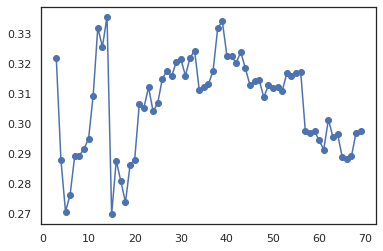

In [133]:
plt.plot(k_clusters,silhouette)
plt.scatter(k_clusters,silhouette)

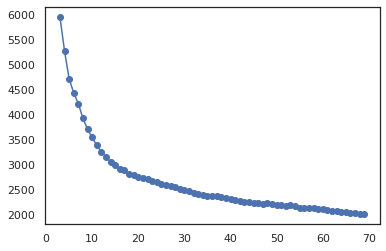

In [134]:
plt.plot(k_clusters,calinski)
plt.scatter(k_clusters,calinski)

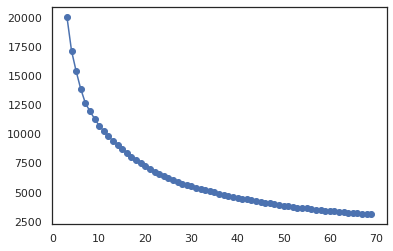

In [135]:
plt.scatter(k_clusters, inertia)
plt.plot(k_clusters, inertia)

Na podstawie powyższych metod można określić, że optymalna ilość klastrów to 12-14. Jest to o tyle interesujące, że mamy 13 różnych rodzin styli. Zobaczmy, jak te dane się grupują w 13 klastrów.

In [136]:
labels_true = beers_out['style family']

km = KMeans(n_clusters=13, random_state=random_state )
km.fit(beers_cluster)

labels = km.labels_

print('Cluster count: %d' % km.n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true , labels))
print("Completeness: %0.3f" % completeness_score(labels_true , labels))
print("V-measure: %0.3f" % v_measure_score(labels_true , labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true , labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true , labels))
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(beers_cluster, labels))

Cluster count: 13
Homogeneity: 0.509
Completeness: 0.488
V-measure: 0.498
Adjusted Rand Index: 0.312
Adjusted Mutual Information: 0.497
Silhouette Coefficient: 0.325


Metryki wskazują, że klastrowanie niekoniecznie odpowiada rodzinom styli. Dla przypomnienia:

*   **Homogeneity** - jeśli klastry zawierają tylko obserwacje będące członkami pojedynczej klasy. Innymi słowy np. klaster X zawera tylko pale lagery
*   **Completeness** - jeśli wyszstkie punkty należące do danej klasy są w tym samym klastrze. Innymi słowy np. wszstkie pale lagery należą do klastra X
*   **V-measure** to średnia harmoniczna z powyższych

Wartości metryk zawierają się w zakresie 0-1 i im więcej tym lepiej,

Sprawdźmy teraz jak dane się rozkładają w klastrach i zobaczmy jakie piwa wpadły do klastra razem z popularnym Tyskim (spodziawalibyśmy się lagerów lub pale lagerów):

In [137]:
beers_out['km'] = km.predict(beers_cluster)

name = 'tyskie'

beers_out[['name', 'styles_clean', 'styles', 'bjcp categories', 'style family']][beers_out['km'] == 
                        beers_out.loc[beers_out[beers_out['name'] == name].index[0], 'km']].head(5)

,name,styles_clean,styles,bjcp categories,style family
4219,breclav kanec 13 nachmelena za studena,india pale lager,international pale lager,international lager,pale lager
4220,hostan hradni,lager,international pale lager,international lager,pale lager
4221,ayinger lager hell,lager,international pale lager,international lager,pale lager
4223,fresh hop pilsner,lager,international pale lager,international lager,pale lager
4224,draf mocne,strong lager,international pale lager,international lager,pale lager


I rzeczywiście mamy zwykłe, normalne pale lagery.

### DBSCAN

Klastrowanie k-means zakłada, że klastry są w przybliżeniu równe co do liczności. W naszym przypadku nie ma to miejsca. W związku z tym użyjemy algorytmu, który zakłada, że klastry mogą nie być równe.

In [138]:
labels_true = beers_out['bjcp categories']

db = DBSCAN(eps=0.5).fit(beers_cluster)
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Cluster count: %d' % n_clusters_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(beers_cluster, labels))

Cluster count: 23
Homogeneity: 0.543
Completeness: 0.763
V-measure: 0.635
Adjusted Rand Index: 0.428
Adjusted Mutual Information: 0.631
Silhouette Coefficient: 0.144


DB scan zwrócił 23 klastry. Jest to liczba zbliżona do 26 kategorii BJCP. Porównanie z tą kolumną wskazuje na metrykę completness równą 0.76 co jest znacząco wyższą wartością od KMeans (0.48). Homeginity nie uległo tak znacznej poprawie.

## Klasyfikator styli piwa

Sprawdźmy czy na podstawie posiadanych cech uda się zbudować klasyfikator.
Stworzę najpierw generyczną funkcję, do testowania różnych klasyfikatorów.

In [0]:
def classifier(X,y, model, standarize=False, k_fold = False, n_fold = 5, 
                  gridsearch=False, grid_params=None, random_state=random_state, save=False):
  
  X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=0.2, random_state=random_state)

  if standarize:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

  if k_fold:
    kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=random_state)

    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    
    #print("Cross-Validation Score: " + str(scores))
    #print("Cross-Validation Mean: %0.3f" % np.mean(scores))

  if gridsearch:
    grid = GridSearchCV(estimator=model, param_grid=grid_params, cv=kfold, verbose=0)
    grid.fit(X_train, y_train)
    y_hat = grid.predict(X_test)

    if save==True:
      joblib.dump(grid, dump_path + "model.joblib.dat")  

    return([scores, np.mean(scores), grid.best_params_, grid.best_score_, classification_report(y_test, y_hat), f1_score(y_test, y_hat, average='micro') ])
  else:
    model.fit(X_train, y_train)
    y_hat=model.predict(X_test)

    if save==True:
      joblib.dump(model, dump_path + "model.joblib.dat") 

    return([scores, np.mean(scores), None, None, classification_report(y_test, y_hat), f1_score(y_test, y_hat, average='micro') ])
  

Sprawdźmy najpierw jak różne klasyfikatory działają z parametrami "z pudełka", bez tuningowania.

In [140]:
names = ["KNearest Neighbors", "Logistic Regression", "Decision Tree", "Random Forest", "Neural Net", "LGBM"]

classifiers = [KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(),
    RandomForestClassifier(), MLPClassifier(), lgb.LGBMClassifier()]

results = []
for name, clf in zip(names, classifiers):
  results.append(classifier(beers_cluster, beers_out['style family'], clf, k_fold=True))

results = pd.DataFrame(results, columns=["cv_scores", "cv_mean", "grid_best_params", "grid_best_score", "class_report", "f1_test"])
results['name'] = names
results

,cv_scores,cv_mean,grid_best_params,grid_best_score,class_report,f1_test,name
0,"[0.8152359295054008, 0.8004548038658329, 0.796...",0.807211,None,None,precision recall f1-score ...,0.803458,KNearest Neighbors
1,"[0.7413303013075612, 0.7470153496304719, 0.748...",0.746702,None,None,precision recall f1-score ...,0.752502,Logistic Regression
2,"[0.8061398521887436, 0.7896532120523024, 0.806...",0.802776,None,None,precision recall f1-score ...,0.818016,Decision Tree
3,"[0.8357021034678794, 0.8283115406480955, 0.839...",0.833827,None,None,precision recall f1-score ...,0.836215,Random Forest
4,"[0.8209209778283115, 0.8038658328595794, 0.798...",0.810850,None,None,precision recall f1-score ...,0.816652,Neural Net
5,"[0.8527572484366117, 0.839681637293917, 0.8503...",0.847589,None,None,precision recall f1-score ...,0.845769,LGBM


Najlepiej poradził sobie LGBM, ale sprawdźmy jak to wygląda w szczegółach: 

In [141]:
print(results['class_report'][results['name']=='LGBM'].values[0])

              precision    recall  f1-score   support

   amber ale       0.66      0.60      0.63        72
 amber lager       0.65      0.62      0.64        55
        bock       0.96      0.94      0.95        53
   brown ale       1.00      0.71      0.83         7
  dark lager       0.96      0.98      0.97        54
         ipa       0.88      0.95      0.92       484
    pale ale       0.92      0.75      0.83       187
  pale lager       0.77      0.82      0.79       388
     pilsner       0.69      0.71      0.70       198
      porter       0.99      0.99      0.99       104
       stout       1.00      1.00      1.00       240
  strong ale       0.90      0.92      0.91       102
  wheat beer       0.78      0.71      0.74       254

    accuracy                           0.85      2198
   macro avg       0.86      0.82      0.84      2198
weighted avg       0.85      0.85      0.84      2198



F1-score najniższy jest dla Amber Ale i wynosi 0.65, najwyższy dla Stouta i wynosi 1. Przeprowadzę teraz tuning parametrów dla LGBM (można by przeprowadzić analogiczną procedurę dla pozostałych klasyfikatorów tworząc odpowiedni słownik parametrów, ale trwa to długo, więc zostanę przy jednym klasyfikatorze).

Tworzę słownik parametrów do przeszukania, potem obiekt klasyfikatora LGBM, gdzie z góry podaję część parametrów, a następne uruchamiam napisaną wcześniej funkcję z gridsearchem.

In [0]:
if calculate_everything:
  lgbm_grid_params = {
      'learning_rate': [0.1, 0.01,0.005],
      'n_estimators': [50,100,400,600,1000],
      'max_depth': [10,50,100,200],
      'num_iteration': [10,50,100,200]
      }

  model = lgb.LGBMClassifier(boosting_type= 'gbdt', objective = 'multiclass',
                             num_class=13)

  lgbm_result = classifier(beers_cluster, beers_out['style family'], model, 
                              k_fold=True, grid_params=lgbm_grid_params, 
                              gridsearch=True, save=True)

  
  lgbm_best = pd.DataFrame([lgbm_result])

  pd.to_pickle(lgbm_best, dump_path + 'lgbm_result.pkl' )
else:
  lgbm_best=pd.read_pickle(dump_path + 'lgbm_result.pkl')

Zobaczmy feature importances:

Text(0.5, 1.0, 'LGBM feature importances')

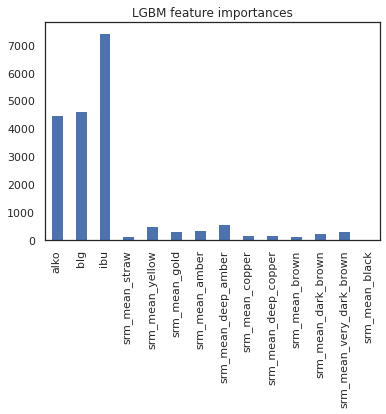

In [143]:
model = joblib.load(dump_path + "model.joblib.dat")

pd.Series(model.best_estimator_.feature_importances_, 
          index=beers_cluster.columns).plot(kind='bar')
plt.title('LGBM feature importances')

Widzimy, że najważniejsze cechy to IBU, BLG i alkohol.

In [144]:
print('Cross-validation mean score: %0.3f' % lgbm_best[1])
print("Grid search best params: " )
print(lgbm_best[2].values[0])
print('Grid search best score: %0.3f' % lgbm_best[3])
print('Classification report:')
print(lgbm_best[4].values[0])

Cross-validation mean score: 0.848
Grid search best params: 
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 50, 'num_iteration': 50}
Grid search best score: 0.849
Classification report:
              precision    recall  f1-score   support

   amber ale       0.70      0.62      0.66        72
 amber lager       0.70      0.69      0.70        55
        bock       0.98      0.96      0.97        53
   brown ale       1.00      0.71      0.83         7
  dark lager       0.96      0.98      0.97        54
         ipa       0.89      0.96      0.92       484
    pale ale       0.94      0.75      0.83       187
  pale lager       0.78      0.83      0.80       388
     pilsner       0.68      0.72      0.70       198
      porter       0.99      0.99      0.99       104
       stout       1.00      1.00      1.00       240
  strong ale       0.92      0.92      0.92       102
  wheat beer       0.79      0.70      0.75       254

    accuracy                           0.85    

Wyniki uległy nieznacznej poprawie. Na tym kończę proces budowy klasyfikatorów dla stylu piwa, na podstawie alkoholu, BLG, IBU i koloru piwa. Osiągnięty wynik f1 na analizowanych danych to 0.85.

## Sentyment komentarzy

W tej części spróbuję zweryfikować czy da się zbudować model określający sentyment komentarzy.

In [145]:
len(comments_rated)

12934

Biorąc pod uwagę wielość zbioru zbuduję klasyfikator binarny. Przy tak niewielkim zbiorze i dystrybuji ocen (opis w sekcji eksploaracyjnej), budowa bardziej skomplikowanego klasyfikatora nie ma sensu. W tym celu, przekonwertuję najpierw ocenę z komenarza na binarną wartość, tj. jeśli ocena >=6 to pozytywna, jeśli <6 to negatywna.

In [146]:
comments_rated['sent'] = (comments_rated['rating'] >= 6.0).astype(int)
comments_rated.head(2)

,koment,name,user,date,rating,taste,smell,appearance,label_name,label_user,sent
1450,Lekko gryzace nienachalne wysycenie. Aromat wi...,psotnik nocna zmiana,0xhiryuu,2019-07-21 01:13:56,9.0,9.0,9.0,9.0,8401,1,1
3085,"Taka woda ale ze spirytusem, mozna se w sumie ...",kent szlachetny jasne mocne,abiseth,2019-01-26 22:25:31,2.0,2.0,1.0,2.0,5009,4,0


In [147]:
comments_rated['sent'].value_counts()/len(comments_rated['sent'])

1    0.772228
0    0.227772
Name: sent, dtype: float64

Zbiór jest również dość skrzywiony, ze znaczną przewagą ratingu pozytywnego. Będzie trzeba to uzględnić w procesowaniu dalszym.

Zanim przystąpimy do analizy sentymentu należy dokonać preprocessingu tekstu, tokenizacji i w końcu dojść jakiejś reprezentacji liczbowej, czy to one-hot, n-gramy albo tf-idf. Problem w tym, że te reprezentacje mogą być gigantyczne i szalenie nieefektywne. Jeśli zaś chodzi o tekst z jakim mamy do czynienia to jest on w języku polskim, w którym występuje choćby odmiana przez przypadki. Jest to tekst z komentarzy z komentarzy internetowych, mający niewiele wspólnego z poprawną polszczyzną, dodatkowo pozbawiony polskich znaków diakrytycznych (co ma swoje zalety i wady).

### Preprocessing

W pierwszym kroku wykonuję następujące czynności:


1.   Usuwam znaki interpunkcyjne.
2.   Zmieniam wszystkie litery na małe
3.   Usuwam tzw. stop words
4.   Usuwam końcówki fleksyjne (tzw. stemming). Jest to o tyle słabe w tym zbiorze danych, że analizowane dane są pozbawione polskich znaków, a te są istotne dla poprawności stemmingu.
5.   Tworzę listy z wynikami przeliczeń, które będą wykorzystane w dalszych krokach analiz.



In [148]:
nltk.download('punkt') #stemmer wymagal tego pakietu

#zrodlow: https://github.com/bieli/stopwords/blob/master/polish.stopwords.txt
stop_words = ['a','aby','ach','acz','aczkolwiek','aj','albo','ale','alez','ależ',
              'ani','az','aż','bardziej','bardzo','beda','bedzie','bez','deda','będą',
              'bede','będę','będzie','bo','bowiem','by','byc','być','byl','byla',
              'byli','bylo','byly','był','była','było','były','bynajmniej','cala',
              'cali','caly','cała','cały','ci','cie','ciebie','cię','co','cokolwiek',
              'cos','coś','czasami','czasem','czemu','czy','czyli','daleko','dla',
              'dlaczego','dlatego','do','dobrze','dokad','dokąd','dosc','dość',
              'duzo','dużo','dwa','dwaj','dwie','dwoje','dzis','dzisiaj','dziś',
              'gdy','gdyby','gdyz','gdyż','gdzie','gdziekolwiek','gdzies','gdzieś',
              'go','i','ich','ile','im','inna','inne','inny','innych','iz','iż',
              'ja','jak','jakas','jakaś','jakby','jaki','jakichs','jakichś','jakie',
              'jakis','jakiś','jakiz','jakiż','jakkolwiek','jako','jakos','jakoś',
              'ją','je','jeden','jedna','jednak','jednakze','jednakże','jedno',
              'jego','jej','jemu','jesli','jest','jestem','jeszcze','jeśli',
              'jezeli','jeżeli','juz','już','kazdy','każdy','kiedy','kilka',
              'kims','kimś','kto','ktokolwiek','ktora','ktore','ktorego','ktorej'
              ,'ktory','ktorych','ktorym','ktorzy','ktos','ktoś','która','które',
              'którego','której','który','których','którym','którzy','ku','lat',
              'lecz','lub','ma','mają','mało','mam','mi','miedzy','między','mimo',
              'mna','mną','mnie','moga','mogą','moi','moim','moj','moja','moje',
              'moze','mozliwe','mozna','może','możliwe','można','mój','mu','musi',
              'my','na','nad','nam','nami','nas','nasi','nasz','nasza','nasze',
              'naszego','naszych','natomiast','natychmiast','nawet','nia','nią',
              'nic','nich','nie','niech','niego','niej','niemu','nigdy','nim',
              'nimi','niz','niż','no','o','obok','od','około','on','ona','one',
              'oni','ono','oraz','oto','owszem','pan','pana,','pani','po,','pod',
              'podczas','pomimo','ponad','poniewaz','ponieważ','powinien','powinna',
              'powinni','powinno','poza','prawie','przeciez','przecież','przed',
              'przede','przedtem','przez','przy','roku','rowniez','również','sam'
              ,'sama','są','sie','się','skad','skąd','soba','sobą,''sobie','sposob',
              'sposób','swoje','ta','tak','taka','taki','takie','takze','także',
              'tam','te','tego','tej','ten','teraz','też','to','toba','tobą',
              'tobie','totez','toteż','totobą','trzeba','tu','tutaj','twoi',
              'twoim','twoj','twoja','twoje','twój','twym','ty','tych','tylko',
              'tym','u','w','wam','wami','was','wasz','wasza','wasze','we','według',
              'wiele','wielu','więc','więcej','wlasnie','właśnie','wszyscy','wszystkich',
              'wszystkie','wszystkim','wszystko','wtedy','wy','z','za','zaden','zadna',
              'zadne','zadnych','zapewne','zawsze','ze','zeby','zeznowu','zł','znow',
              'znowu','znów','zostal','został','żaden','żadna','żadne','żadnych','że','żeby']

stemmer = StempelStemmer.polimorf() #ste

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Loading:  99%|█████████▉| 11290212/11368252 [00:11<00:00, 830806.64bytes/s]

In [149]:
comments_rated['plain'] = comments_rated['koment'].str.translate(str.maketrans('', '', string.punctuation)).str.strip().str.lower()
comments_list = comments_rated['plain'].tolist()

filename = dump_path + 'comments_list.pkl'
outfile = open(filename,'wb')
pickle.dump(comments_list,outfile)
outfile.close()

sents = [] #lista komentarzy pocietych na slowa przeroboneh stemmerem, lista list
all_words = [] #lista wszystkich slow
comments_preprocessed = [] 
for sent in comments_list:
    tmp = word_tokenize(sent)

    k=[]
    for word in tmp:
      if not word in stop_words:
        k.append(stemmer.stem(word))
        all_words.append(stemmer.stem(word))
    
    sents.append(k)
    comments_preprocessed.append(' '.join(map(str,k)))



Loading: 100%|██████████| 11368252/11368252 [00:30<00:00, 830806.64bytes/s]

Przykład, jak wygląda komentarz po zmianach:

In [150]:
print(' '.join(sents[0]))
print(comments_preprocessed[0])
print(comments_rated['koment'].iloc[0])

lekki gryzace nienachalny wysycić aromat wiosenny puniętro lekki sosnowopistacjowy goryczka sreeć wysoki doskonal piwo nocny
lekki gryzace nienachalny wysycić aromat wiosenny puniętro lekki sosnowopistacjowy goryczka sreeć wysoki doskonal piwo nocny
Lekko gryzace nienachalne wysycenie. Aromat wiosenny ;p, lekko sosnowo-pistacjowy. Goryczka srednio wysoka. Doskonale piwo nocne :) 


I wielkość naszego słownika:

In [151]:
len(all_words)

568334

### Prosty model: tf-idf i RandomForest

Mając już uproszczone wersje zdań i wszystkie słowa, możemy teraz stworzyć tokeny za pomocą modelu tf-idf (od razu arbitralnie ograniczę liczbę słów do 3000 (drastyczne skraca czas przeliczeń i potrzebnych zasobów - macierze nie są tak wielkie) w zbiorze oraz ustalam max_df na 0.6, co oznacza że użyte słowa nie pojawiają się w więcej jak 60% recenzjach, w celu odsiania popularnych słów) :

In [0]:
tfidfvect = TfidfVectorizer(max_features=3000, max_df=0.6)
X = tfidfvect.fit_transform(comments_preprocessed).toarray()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, comments_rated['sent'],stratify=comments_rated['sent'], test_size=0.2, random_state=random_state)

In [154]:
text_clsf = RandomForestClassifier(random_state=random_state)  
text_clsf.fit(X_train, y_train)

y_hat = text_clsf.predict(X_test)
	 
print(confusion_matrix(y_test,y_hat))  
print(classification_report(y_test,y_hat))  
print('Accuracy score: %.03f' % accuracy_score(y_test, y_hat))
print('Recall score: %.03f' % recall_score(y_test, y_hat))

[[ 231  358]
 [  68 1930]]
              precision    recall  f1-score   support

           0       0.77      0.39      0.52       589
           1       0.84      0.97      0.90      1998

    accuracy                           0.84      2587
   macro avg       0.81      0.68      0.71      2587
weighted avg       0.83      0.84      0.81      2587

Accuracy score: 0.835
Recall score: 0.966


Klasyfikator osiągął accuracy na poziomie 83% i recall 97%. Jednak jak widzimy z raportu, jest to "zasługą" silnego skrzywienia danych. O ile model dobrze radzi sobie z klasyfikowaniem pozytywnych recenzji, których jest dużo, to źle mu idzie z negatywnymi, co skutkuje dużą ilością false positive i niskim recall. 

Zobaczymy czy inne modele poradzą sobie lepiej.

### Word embeddings 

Jak już zostało wspomniane, macierze tf-idf, czy bag-of-words mogą być gigantyczne. Dlatego też efektywniej jest reprezentować słowa za pomocą wektorów i stworzyć tzw. word embeddings. Ta technika pozwala również na "operacje matematyczne" na słowach. Skoro są reprezentowane jako wektory, to możemy je dodawać i odejmować jak wektory.

Najpierw zbuduję ręcznie model embeddings za pomocą biblioteki Keras. Następnie skorzystam z gotowych modeli.

Mając już uproszczone wersje zdań, możemy je teraz przemapować na liczby. Skorzystam z obiektu Tokenizer(), który zwróci tekst zakodowany jako intigery, czyli wspomniane embeddings:


In [0]:
vocab =len(set(all_words)) +1 #rozmiar słownika wszystkich słów w tekście

t=keras.preprocessing.text.Tokenizer()
t.fit_on_texts(comments_preprocessed)
sequences = t.texts_to_sequences(comments_preprocessed)

In [156]:
print(comments_preprocessed[0])
print(sequences[0])

lekki gryzace nienachalny wysycić aromat wiosenny puniętro lekki sosnowopistacjowy goryczka sreeć wysoki doskonal piwo nocny
[5, 4253, 1715, 15, 4, 4021, 1716, 5, 13482, 3, 107, 17, 732, 1, 7869]


Pierwszą warstwą w sieci będzie warstwa typu Embedding, która przyjmuje na wejściu macierz o stałym wymiarze. W związku z tym musimy doprowadzić zdania do takiej postaci, by miały jednakową długość, czyli dokonać tzw. paddingu. W tym celu najpierw znajdę najdłuższe zdanie, a potem wyrównam do niego resztę za pomocą funkcji pad_sequences. Istotny jest parametr padding='post', jeśli będzie się chciało używać potem warstw RNN. Jednak użycie RNN może nie być wskazane, jako, że zbiór z jakim mamy do czynienia jest mały (13k komentarzy) i silnie skrzywiony. Użycie RNN może być strzelaniem z aramty do muchy, skutkującym znacznym overfittingiem. Sprawdzimy to.

In [157]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

longest_s = find_max_list(sequences)
print('Max sentence length: %d' % longest_s)

Max sentence length: 290


In [158]:
padded_embeddings = keras.preprocessing.sequence.pad_sequences(sequences, longest_s, padding='post')
print(padded_embeddings[0])

[    5  4253  1715    15     4  4021  1716     5 13482     3   107    17
   732     1  7869     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

Jako, że nasz zbiór jest skrzywiony sprawdźmy jeszcze wagi klas, tak żeby przekazać je potem do modelu.

In [159]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(comments_rated['sent']),
                                                 comments_rated['sent'])
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.1951799049558725, 1: 0.6474769723668402}

Teraz możemy zbudować sieć. Model będzie typu Sequential. Pierwszą warstwą, jak zostało wspomniane, będzie warstwa Embedding. Następnie warstwa Flatten, żeby przekonwertować wejściowe dane do postaci jednowymiarowej, następnie jedna warstwa ukrytą z 10 neuronami i warstwa wyjściową z jednym neuronem i aktywacją sigmoid, jako że to klasyfikacja binarna. Dodatkowo dodam dwie warstwy dropoutu, żeby zmniejszyć możliwość przetrenowania sieci.

Sieć jest malutka i bardzo prosta, ale i tak jest to aż nadto do takiej ilości danych, o czym zaraz będzie można się przekonać.

Całość zostanie opakowana w funkcję, tak żeby dopasować model kilka razy do danych i obliczyć średnie wyniki, żeby "pozbyć" się kwesti losowości wag i różnych wyników.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(padded_embeddings, 
                                                    comments_rated['sent'],
                                                    stratify=comments_rated['sent'],
                                                    test_size=0.2, 
                                                    random_state=random_state)

In [161]:
def fit_model(X_train, X_test, y_train, y_test):
  model = keras.models.Sequential([
                    keras.layers.Embedding(vocab, 40, input_length=longest_s),#, mask_zero=True),
                    keras.layers.Flatten(),
                    keras.layers.Dropout(rate=0.2),
                    keras.layers.Dense(10,activation="elu", kernel_initializer="he_normal"),
                    #GRU(5),
                    keras.layers.Dropout(rate=0.2),
                    keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, )

  hist = model.fit(X_train, y_train, epochs=5, verbose=0, 
                 validation_split=0.2, 
                 callbacks=[early_stopping_cb],batch_size=32, class_weight=class_weight_dict )
  y_hat = model.predict_classes(X_test)

  return(confusion_matrix(y_test,y_hat),classification_report(y_test,y_hat, output_dict=True),
         accuracy_score(y_test, y_hat), recall_score(y_test, y_hat), hist)

results=[]

for i in range(10):
  results.append(fit_model(X_train, X_test, y_train, y_test))
  print('Pass: %d' % i)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Pass: 0
Pass: 1
Pass: 2
Pass: 3
Pass: 4
Pass: 5
Pass: 6
Pass: 7
Pass: 8
Pass: 9


In [162]:
a = np.array(results)
print("['0']['precison']: %.3f" % np.mean([i['0']['precision'] for i in a[:,1]])) 
print("['0']['recall']: %.3f" % np.mean([i['0']['recall'] for i in a[:,1]]))
print("['0']['f1-score']: %.3f" % np.mean([i['0']['f1-score'] for i in a[:,1]]))
print("['1']['precison']: %.3f" % np.mean([i['1']['precision'] for i in a[:,1]])) 
print("['1']['recall']: %.3f" % np.mean([i['1']['recall'] for i in a[:,1]]))
print("['1']['f1-score']: %.3f" % np.mean([i['1']['f1-score'] for i in a[:,1]]))
print("['accuracy']['f1-score']: %.3f" % np.mean([i['accuracy'] for i in a[:,1]]))
print("['macro avg']['precison']: %.3f" % np.mean([i['macro avg']['precision'] for i in a[:,1]])) 
print("['macro avg']['recall']: %.3f" % np.mean([i['macro avg']['recall'] for i in a[:,1]]))
print("['macro avg']['f1-score']: %.3f" % np.mean([i['macro avg']['f1-score'] for i in a[:,1]]))
print("['weighted avg']['precison']: %.3f" % np.mean([i['weighted avg']['precision'] for i in a[:,1]])) 
print("['weighted avg']['recall']: %.3f" % np.mean([i['weighted avg']['recall'] for i in a[:,1]]))
print("['weighted avg']['f1-score']: %.3f" % np.mean([i['weighted avg']['f1-score'] for i in a[:,1]]))
print("Accuracy: %.3f" % np.mean(a[:,2]))
print("Recall: %.3f" % np.mean(a[:,3]))

['0']['precison']: 0.658
['0']['recall']: 0.646
['0']['f1-score']: 0.652
['1']['precison']: 0.896
['1']['recall']: 0.901
['1']['f1-score']: 0.898
['accuracy']['f1-score']: 0.843
['macro avg']['precison']: 0.777
['macro avg']['recall']: 0.773
['macro avg']['f1-score']: 0.775
['weighted avg']['precison']: 0.842
['weighted avg']['recall']: 0.843
['weighted avg']['f1-score']: 0.842
Accuracy: 0.843
Recall: 0.901


Sieć osiągnęła niewątpliwie lepsze wyniki niż RandomForest (recall klasy '0' wynosi 61% vs 35%) i macro avg F1-score 77% vs 69%. Jednak sieć również radzi sobie gorzej z komentarzami negatywnymi, co nie jest zaskoczeniem.

Spójrzmy jeszcze na krzywe accuracy i loss dla zbioru testowego i walidacyjnego, dla jednego z przebiegów modelu.

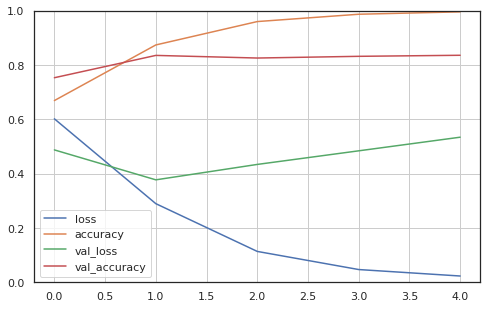

In [163]:
pd.DataFrame(a[0,4].history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Krzywe jasno pokazują, że sieć mimo swojej prostoty silnie przetrenowuje. Ilość komentarzy, a już zwłaszcza negatywnych jest mała i aby uzyskać lepsze wyniki należałoby zwiększyć ilość danych. Sieć raczej nie wiele da się bardziej uprościć. Co oczywiste, skomplikowanie sieci nie poprawi wyników, więc nie będę budować sieci RNN, dobrze się sprawdzających przy analizach języka naturalnego. Po prostu sieć z komórkami typu GRU czy LSTM jeszcze szybciej by przetrenowała dane.

To co możemy sprawdzić to użycie innych embeddingów, np. poprzez skorzystanie z gotowego modelu.

### GloVe

W poprzednim kroku korzystaliśmy z ręcznie utworzonej warstwy embedding, która została zainicjalizowana losowymi wagami. Tym razem skorzystam z gotowego modelu embeddings, w ramach transfer learning. Model pobrany stąd: https://github.com/sdadas/polish-nlp-resources 

Wczytuję wektory z pliku:

In [164]:
embeddings_index = {}
with open(data_path + 'glove_300_3_polish.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1926320 word vectors.


Tworzę embedding_matrix, czyli macierz zawierającą reprezentację wektorów GloVe słów z komentarzy piw (wykorzystuję indexy słów z poprzednio użytego Tokenizera):
 

In [165]:
hits = 0
misses = 0
embedding_matrix = np.zeros((vocab, 300))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1


print("Converted %d words and %d unfound" % (hits, misses))

Converted 12308 words and 18552 unfound


Jak widać, znalezionych zostało 12555 słów, czyli zaledwie 40%. Im więcej brakujących słów, tym gorzej dla modelu, ponieważ nie wiadomo jak są one reprezentowane. Jest to efekt tego, że komentarze stanowią przykład "mowy internetowej", a nie poprawnych tekstów, na których tworzono użyty model. Niemniej jednak spróbujemy go użyć.

Analogicznie jak poprzenio, wykorzystuję funkcję tworzącą i dopasowującą model, tylko tym razem w pierwszej warstwie sieci podaję wagi w postaci embedding_matrix i ustalam, że ta warstwa nie powinna być trenowana.

In [166]:
def fit_model(X_train, X_test, y_train, y_test):
  model = keras.models.Sequential([
                    keras.layers.Embedding(vocab, 300, weights=[embedding_matrix], input_length=longest_s, trainable=False),#, mask_zero=True),
                    keras.layers.Flatten(),
                    keras.layers.Dropout(rate=0.2),
                    keras.layers.Dense(10,activation="elu", kernel_initializer="he_normal"),
                    #GRU(5),
                    keras.layers.Dropout(rate=0.2),
                    keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, )

  hist = model.fit(X_train, y_train, epochs=5, verbose=0, 
                 validation_split=0.2, 
                 callbacks=[early_stopping_cb],batch_size=32, class_weight=class_weight_dict )
  y_hat = model.predict_classes(X_test)

  return(confusion_matrix(y_test,y_hat),classification_report(y_test,y_hat, output_dict=True),
         accuracy_score(y_test, y_hat), recall_score(y_test, y_hat), hist)

results=[]

for i in range(10):
  results.append(fit_model(X_train, X_test, y_train, y_test))
  print('Pass: %d' % i)

Pass: 0
Pass: 1
Pass: 2
Pass: 3
Pass: 4
Pass: 5
Pass: 6
Pass: 7
Pass: 8
Pass: 9


In [167]:
a = np.array(results)
print("['0']['precison']: %.3f" % np.mean([i['0']['precision'] for i in a[:,1]])) 
print("['0']['recall']: %.3f" % np.mean([i['0']['recall'] for i in a[:,1]]))
print("['0']['f1-score']: %.3f" % np.mean([i['0']['f1-score'] for i in a[:,1]]))
print("['1']['precison']: %.3f" % np.mean([i['1']['precision'] for i in a[:,1]])) 
print("['1']['recall']: %.3f" % np.mean([i['1']['recall'] for i in a[:,1]]))
print("['1']['f1-score']: %.3f" % np.mean([i['1']['f1-score'] for i in a[:,1]]))
print("['accuracy']['f1-score']: %.3f" % np.mean([i['accuracy'] for i in a[:,1]]))
print("['macro avg']['precison']: %.3f" % np.mean([i['macro avg']['precision'] for i in a[:,1]])) 
print("['macro avg']['recall']: %.3f" % np.mean([i['macro avg']['recall'] for i in a[:,1]]))
print("['macro avg']['f1-score']: %.3f" % np.mean([i['macro avg']['f1-score'] for i in a[:,1]]))
print("['weighted avg']['precison']: %.3f" % np.mean([i['weighted avg']['precision'] for i in a[:,1]])) 
print("['weighted avg']['recall']: %.3f" % np.mean([i['weighted avg']['recall'] for i in a[:,1]]))
print("['weighted avg']['f1-score']: %.3f" % np.mean([i['weighted avg']['f1-score'] for i in a[:,1]]))
print("Accuracy: %.3f" % np.mean(a[:,2]))
print("Recall: %.3f" % np.mean(a[:,3]))

['0']['precison']: 0.446
['0']['recall']: 0.524
['0']['f1-score']: 0.480
['1']['precison']: 0.852
['1']['recall']: 0.807
['1']['f1-score']: 0.828
['accuracy']['f1-score']: 0.742
['macro avg']['precison']: 0.649
['macro avg']['recall']: 0.665
['macro avg']['f1-score']: 0.654
['weighted avg']['precison']: 0.760
['weighted avg']['recall']: 0.742
['weighted avg']['f1-score']: 0.749
Accuracy: 0.742
Recall: 0.807


Jak widać sieć oparta o model GloVe osiągnęła gorsze wyniki niż porsty model stworzony wcześniej. Dzieje się tak ponieważ model GloVe mimo, że dotycy tego samego języka był trenowany na "poprawnym" języku polskim. Repo githuba, z którego pobrano model GloVe zawiera też inne modele, ale ograniczę się tylko do jednego. Nie sądzę, że inne dadzą spektakulranie lepsze wyniki z podanych już powodów, a powyższy kod prezentuje jak skorzystać z gotowego modelu i transfer learingu. 

## Fałszywe komentarze

Spróbujemy teraz stworzyć sieć do generowania fałszywych komentarzy. 

Zaznaczam, że **poniższy kod opiera się lub jest fragmentami skopiowany** z tutorialu Jasona Brownlee "[*Text Generation With LSTM Recurrent Neural Networks in Python with Keras*](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/)", książki Aureliena Gerona "[*Hands‑On Machine Learning with Scikit‑Learn, Keras, and TensorFlow*](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)" i artykułu Patricka von Platena 
"[*How to generate text: using different decoding methods for language generation with Transformers*](https://huggingface.co/blog/how-to-generate)". Jako, że chciałem się nauczyć koncepcji i technik związanych z generowaniem tekstu, toteż uczyniłem to na analizowanym zbiorze danych i umieściłem w pracy.

Wczytuję przygotwane wcześniej już komentarze (przy puszczaniu kodu end-to-end, ten krok jest niepotrzebny, ale w trakcie pisania pracy nie puszczałem wszystkiego od początku za każdym razem). Umożliwa przejście tylko tej sekcji, bez uruchamiania jakichkolwiek fragemntów kodu znajdującego się powyżej, poza importami.

In [0]:
infile = open(dump_path + 'comments_list.pkl','rb')
comments_list = pickle.load(infile)
infile.close()

Łączę wczytaną listę w jeden długi tekst:

In [169]:
text = ' '.join(comments_list)
print('Total no. of characters: %d' % len(text))

Total no. of characters: 5593463


Najpierw skorzystamy ze znanej już klasy Tokenizera, ale tym razem kodujemy znaki (*char_level=True*), nie całe słowa. Czmeu? Ponieważ słów mimo wszystko mamy w tym zbiorze niewiele, a znaków jest więcej:

In [170]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(text)
print('piwo = '+ str(tokenizer.texts_to_sequences(["piwo"])))

max_id = len(tokenizer.word_index) # liczba uniklamych znakow
dataset_size = tokenizer.document_count #laczna liczba znakow
print('No of unique caracters: %d, total number of chars: %d' % (max_id, dataset_size))

piwo = [[17, 5, 8, 4]]
No of unique caracters: 37, total number of chars: 5593463


Mamy 26 liter + 10 cyfr + spacja, czyli 37 więc jest ok.

Zamieniam cały tekst na jego numeryczną reprezentację, przy okazji dokonując przesunięcia, tak aby indeksacja  przebiegała od 0, nie od 1:

In [171]:
[encoded] = np.array(tokenizer.texts_to_sequences([text])) -1
print(text[:10])
print(encoded[:10])

lekko gryz
[12  2 10 10  3  0 21 11 14  6]


Następnie wydzielam zbiór treningowy (90% całości). W tekście gdzie mamy ustalony porządek, nie możemy oczywiście dokonać przetasowania zbioru i wybrania losowych elementów, dlatego tak jak przy przygotywaniu zbioru treningowego dla szeregu czasowego, wycinamy fragment odpowiedniej długości oraz przekształcamy za pomocą kersowego Dataset API do struktury Dataset. Jest ona przydatna do reprezentacji dużych zbiorów, które są zbyt duże żeby zmieścić je w RAMie. W tym przypadku wszystko zmieści się w pamięci. Funkcja from_tensor_slices() tworzy tensory z elementów zbioru. 

In [172]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

#wydruk 5 pierwszych elementow, zeby zobaczyc jak wygladaja
for i in dataset.take(5):
  print(i)


tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


W kolejnym kroku tworzymy sekwencje przesuwających się okien o długości 101, gdzie każde kolejne okno przesunięte jest o jeden znak dalej. Na przykładzie zdania 'lubię piwo' i długości okna 3:

dataset = ['l','u','b','i','e',' ','p','i','w','o']
* Okno 1: ['l','u','b']
* Okno 2: ['u','b','i']
* Okno 3: ['b','i','e']
* ...
* Okno -1: ['i','w','o']

Oczywiście w naszym przypadku nie mamy reprezentacji literowej, tylko numeryczną.





In [173]:
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.window(window_length, shift=1, drop_remainder=True) #drop remainder - usuwa ostatnie okno jesli len <100

#dwa pierwsze okna:
for window in dataset.take(2):
  print(list(window.as_numpy_iterator()))

#typ danych kien
for window in dataset.take(2):
  print(window)


[12, 2, 10, 10, 3, 0, 21, 11, 14, 6, 1, 9, 2, 0, 5, 4, 2, 5, 1, 9, 22, 1, 12, 5, 2, 0, 7, 14, 8, 14, 9, 2, 5, 4, 2, 0, 1, 11, 3, 15, 1, 13, 0, 7, 4, 3, 8, 2, 5, 5, 14, 0, 16, 0, 12, 2, 10, 10, 3, 0, 8, 3, 8, 5, 3, 7, 3, 16, 4, 8, 13, 1, 9, 19, 3, 7, 14, 0, 21, 3, 11, 14, 9, 6, 10, 1, 0, 8, 11, 2, 17, 5, 4, 3, 0, 7, 14, 8, 3, 10, 1]
[2, 10, 10, 3, 0, 21, 11, 14, 6, 1, 9, 2, 0, 5, 4, 2, 5, 1, 9, 22, 1, 12, 5, 2, 0, 7, 14, 8, 14, 9, 2, 5, 4, 2, 0, 1, 11, 3, 15, 1, 13, 0, 7, 4, 3, 8, 2, 5, 5, 14, 0, 16, 0, 12, 2, 10, 10, 3, 0, 8, 3, 8, 5, 3, 7, 3, 16, 4, 8, 13, 1, 9, 19, 3, 7, 14, 0, 21, 3, 11, 14, 9, 6, 10, 1, 0, 8, 11, 2, 17, 5, 4, 3, 0, 7, 14, 8, 3, 10, 1, 0]
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


Jak widzimy powyżej, funkcja window stworzyła sekwencje, ale reprezentowane jako typ danych dataset czyli mamy dataset z zagnieżdżonymi datasetami. W tym celu, żeby uzyskać tensory zamiast datasetów używamy funkcji flat map na każdym elemencie datasetu:

In [174]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

for window in dataset.take(2):
  print(window)

tf.Tensor(
[12  2 10 10  3  0 21 11 14  6  1  9  2  0  5  4  2  5  1  9 22  1 12  5
  2  0  7 14  8 14  9  2  5  4  2  0  1 11  3 15  1 13  0  7  4  3  8  2
  5  5 14  0 16  0 12  2 10 10  3  0  8  3  8  5  3  7  3 16  4  8 13  1
  9 19  3  7 14  0 21  3 11 14  9  6 10  1  0  8 11  2 17  5  4  3  0  7
 14  8  3 10  1], shape=(101,), dtype=int64)
tf.Tensor(
[ 2 10 10  3  0 21 11 14  6  1  9  2  0  5  4  2  5  1  9 22  1 12  5  2
  0  7 14  8 14  9  2  5  4  2  0  1 11  3 15  1 13  0  7  4  3  8  2  5
  5 14  0 16  0 12  2 10 10  3  0  8  3  8  5  3  7  3 16  4  8 13  1  9
 19  3  7 14  0 21  3 11 14  9  6 10  1  0  8 11  2 17  5  4  3  0  7 14
  8  3 10  1  0], shape=(101,), dtype=int64)


Następnie mieszamy losowo zbiór i dzielimy na batche o długości 32:

In [0]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

W kolejnym kroku podzielimy batche, tak żeby oddzielić 100 znaków stanowiących predykatory dla kolejnego znaku. Zanim dokonamy właściwego podziału, poniżej ilustracja tego co się stanie.

In [176]:
for i in dataset.take(1):
  print('Przykładowe dwa pierwsze tensory wejściowe, 101 znaków:')
  print(i[:2])
  print('\nOdcięte 100 pierwszych znaków:')
  print(i[:2, :-1])
  print('\nPrzesunięcie +1:')
  print(i[:2, 1:])

Przykładowe dwa pierwsze tensory wejściowe, 101 znaków:
tf.Tensor(
[[ 0 13  3  0 17  6  4  7  5  2  0 20  3  0  6  1  6  7 14  9  6  1 19  0
  10  3  5  9  2 11  5  3  7  2  0 16  4  7  1  0  5  4  2 16  1  8 13  2
  11 14  6  3  7  1  5  2  0  5  4  2  0 15  1 19  1  0 16  3 17 19  1  6
  17 18  0 17  3  0  8  7  3  4  9 22  0  3 17 16  3  7  4  2 17  5  4 10
   3  7  0 16 11]
 [ 7  0  8 13 14 12 18  0 11  3  6  7  3 17  5  4  3  5  2 19  0  9  3 12
   4  0  3 11  4 21  4  5  1 12  0  6  0 20  4  2 17 11  3  5 10  4  0 17
   3 17  1 19  1  9  0 17  3  0 13  2 21  3  0 15  4  5  4 15  1 12  5  1
   0 21  3 11 14  9  6 10  2  0 16  3  8 15  1 10  0  8 12  3 17  3  7 14
   0  4  0 18  9]], shape=(2, 101), dtype=int64)

Odcięte 100 pierwszych znaków:
tf.Tensor(
[[ 0 13  3  0 17  6  4  7  5  2  0 20  3  0  6  1  6  7 14  9  6  1 19  0
  10  3  5  9  2 11  5  3  7  2  0 16  4  7  1  0  5  4  2 16  1  8 13  2
  11 14  6  3  7  1  5  2  0  5  4  2  0 15  1 19  1  0 16  3 17 19  1  6
  17 18  

Odcinamy ostatni znak, zgodnie z ilustracją powyższą, ale na całości:

In [0]:
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

I sprawdźmy czy wyszło tak jak miało być:

In [178]:
for i,j in dataset.take(1):
  print(i[0],j[0])

tf.Tensor(
[ 0  8 10 12  2 16  4  2  0  7  0 19  1 10  4 15  0 13  3  0  7  4 17  6
  4  1 12  2 15  0 10  3  8  6 13  3  7  1 12  3  0  3 10  0 30 28 24  0
 19  2 17  5  1 10  0  5  4  2  0  8  1  0 13  3  0  5  1  0 16  2  7  5
  3  0  6 15  1 11  5  3  7  1  5  2  0 16  4  2  5  4  1 17  6  2  0 16
  3 15  4 15], shape=(100,), dtype=int64) tf.Tensor(
[ 8 10 12  2 16  4  2  0  7  0 19  1 10  4 15  0 13  3  0  7  4 17  6  4
  1 12  2 15  0 10  3  8  6 13  3  7  1 12  3  0  3 10  0 30 28 24  0 19
  2 17  5  1 10  0  5  4  2  0  8  1  0 13  3  0  5  1  0 16  2  7  5  3
  0  6 15  1 11  5  3  7  1  5  2  0 16  4  2  5  4  1 17  6  2  0 16  3
 15  4 15  3], shape=(100,), dtype=int64)


Zgadza się. Ostatnia rzecz o jakiej należy pamiętać, że cyfry z jakimi mamy do czynienia nie reprezentują danych numerycznych tylko litery, czyli de facto zmienne kategoryczne. Czyli stosujemy tu stnadardowe postępowanie i kodujemy zmienne wejściowe jako wekory one-hot:

In [0]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [180]:
for i,j in dataset.take(1):
  print(i[0],j[0])
  print('\n')
  print(i.shape, j.shape)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(100, 37), dtype=float32) tf.Tensor(
[ 0 19  2  8 13  0 16  3  0 16 11  3  8 13 18  0 21  3  7  5  4  1  5 14
  0 20  2 12 21  4  1  5  0  7  4 13  0 19  2  8 13  0 16  3 16 11  1  7
  5 14  0  1  0  5  1  7  2 13  0  9  1 12 10  4  2 15  0 16 11  6 14 19
  2 15  5 14  0 17  3  0 16  4  9  4  1  0 19  1 10  3  0  5  1 16  3 19
  0  4  6  3], shape=(100,), dtype=int64)


(32, 100, 37) (32, 100)


Wynik pokazuje to co chcieliśmy, czyli zestaw stu znaków reprezentowanych jako wektory one-hot o długości 37 (czyli macierz 100x37) stanowi predykatory dla znaku +1, w batchach o rozmiarach 32.

Na koniec zgodnie z dokumentacją obiektu Dataset Keras, dodajemy funkcję prefetch, której celem jest przygotowanie kolejnego batcha. Kiedy podczas treningu przetwarzany jest dany batch, obiekt Dataset będzie równolegle przygotowywać kolejny batch.

In [0]:
dataset = dataset.prefetch(1)

In [182]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 37) (32, 100)


Przed puszczeniem treningu sprawdźmy jeszcze czy mamy dostępne GPU. W przeciwnym wypadku trening może zająć bardzo dużo czasu.

In [0]:
if calculate_everything:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))


W przypadku braku GPU, na Colabie należy je włączyć: Runtime > Change runtime > GPU. W przypadku lokalnej maszyny bez GPU sugeruję skorzystać z wyniku przetrenowanego przemnie modelu.


Jako, że jest to model do predykcji sekwencji, użyjemyy warstw typu LSTM doskonale sprawdzających się w tego typu problemach. Model składa się z dwoch warstw typu LSTM o rozmiarze 128 i dropoutu 0.2. Ustawiamy parametr return_sequences=True, ponieważ  warstwy są dwie i warstwy Dense z 37 wyjściami (przewidywany jest jeden z 37 znaków), opakowanej w warstwę TimeDistributed, tak aby każdy element kroku czasowego został prztworzony przez warstwę Dense.
Z uwagi na czas treningu sieci parametry nie były tuningowane i są przyjęte arbitralnie. Jeden epoch zajmuje ok. 40 min na Colabie, w momencie pisania pracy, więc zrobione są checkpointy modelu, tak by w razie rozłączenia środowiska, łącza, wyczeprania limitów etc. można było łatwo wznowić trening.

Ilość eopchów została ustalona na 50, ale został włączony callback EarlyStopping, tak by w razie braku poprawy modelu, koniec treningu nastapił odpowiednio wcześnie.


In [184]:
if calculate_everything:
  model = keras.models.Sequential([
      keras.layers.LSTM(128, return_sequences=True, input_shape=[None, max_id],
                      dropout=0.2, recurrent_dropout=0.0),
      keras.layers.LSTM(128, return_sequences=True, input_shape=[None, max_id],
                      dropout=0.2, recurrent_dropout=0.0),                     
      keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                      activation="softmax"))
    ])

  model.compile(loss='categorical_crossentropy', optimizer='adam')

  model.summary(line_length=None, positions=None, print_fn=None)
 
  filepath= dump_path +  "double_lstm_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"

  #ustawiam callbacki
  checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True )
  callbacks_list = [checkpoint_cb,early_stopping_cb]

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
  history = model.fit(dataset, epochs=50, callbacks=callbacks_list)
else:
  model = keras.models.load_model( dump_path + 'double_lstm_weights-improvement-09-1.2015.hdf5')
  model.summary(line_length=None, positions=None, print_fn=None)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 128)         84992     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 37)          4773      
Total params: 221,349
Trainable params: 221,349
Non-trainable params: 0
_________________________________________________________________


Poniższa komórka stanowi wznowienie treningu od ostatniego chcekpointu. Jeśli trening nie został przerwany, to oczywiście nie ma potrzeby jej uruchamiać, dlatego wykomentowana:

In [185]:
"""
path= dump_path + 'double_lstm_weights-improvement-02-1.2199.hdf5'
# fit the model
model = tf.keras.models.load_model(path)

filepath= dump_path + "double_lstm_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor='loss', restore_best_weights=True )
callbacks_list = [checkpoint_cb,early_stopping_cb]

model.fit(dataset, initial_epoch=2, epochs=50, callbacks=callbacks_list)
"""

'\npath= dump_path + \'double_lstm_weights-improvement-02-1.2199.hdf5\'\n# fit the model\nmodel = tf.keras.models.load_model(path)\n\nfilepath= dump_path + "double_lstm_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"\n\ncheckpoint_cb = keras.callbacks.ModelCheckpoint(filepath, monitor=\'loss\', verbose=1, save_best_only=True, mode=\'min\')\nearly_stopping_cb = keras.callbacks.EarlyStopping(patience=5, monitor=\'loss\', restore_best_weights=True )\ncallbacks_list = [checkpoint_cb,early_stopping_cb]\n\nmodel.fit(dataset, initial_epoch=2, epochs=50, callbacks=callbacks_list)\n'

Trening zakończył się na 14 epochach. Minimum wartości loss zostało osiągnięte w 9 epochu, miało wartość 1.20146 i nie uległo dlaszej poprawie, dlatego po pięciu kolejnych epochach zdefiniowanych w callbacku EarlyStopping trening się zakończył.

Ładujemy najlepszy model:

In [0]:
model = keras.models.load_model(dump_path + 'double_lstm_weights-improvement-09-1.2015.hdf5')

Żby skorzystać z modelu najpierw funkcja, która przeprocesuje jakiś podany tekst z wykorzystnaiem tokenizera i zakoduje one-hot, tak by stawnowił odpowiendie wejście do modelu:

In [0]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

Model zwróci całą sekwecnję wejściową uzupełnioną o nowy znak, więc wydobędziemy go:

In [188]:
text = "lubie dobre piw"
X_new = preprocess([text])
Y_pred = model.predict_classes(X_new)
print(Y_pred)
print(text + tokenizer.sequences_to_texts(Y_pred + 1)[0][-1])

[[ 3  0  4  3  0 16  3  0 11  6 21 16  4  7  3]]
lubie dobre piwo


Żeby wygenerować tekst posłużymy się funkcją generującą kolejne znaki dla danego tekstu. Jest to proste - generujemy znak z modelu, potem przepuszczamy go przez model itd. Problem w tym, że szybko to prowadzi do powtarzających się tych samych tekstów. Aby tego uninąć skorzystamy tu ze sprytnej funkcji z książki Aureliena Gerona, działającej w następujący sposób:


1.   Zamast znaku bierzemy listę prawdodobieństw kolejnego znaku z modelu.
2.   Obliczamy logarytm prawdopodobieństw i dzielimy go przez parametr *tempearature*. 
3. W ten sposób uzyskujemy rozkład logarytmów prawodpodobieńst stanowiący wejście do funkcji losującej próbkę ze zmiennych kategorialnych. Paramtetr temperature pozwala sterować tym czy największe prawdopdobieństwo wylosowania ma mieć znak z wysokim prawodpodieństwem czy z niskim.
4. Funkcja zwraca wybrany znak.



In [0]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :] #1.
    rescaled_logits = tf.math.log(y_proba) / temperature #2.
    #print(rescaled_logits)
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1 #3.; +1 bo tokenizer idzie od 1
    
    return tokenizer.sequences_to_texts(char_id.numpy())[0] #4.

In [190]:
next_char("lubie dobre piw", temperature=1)

'a'

Na koniec funkcja, ktora utworzy n-elementowy tekst:

In [0]:
def complete_text(text, n_chars=150, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [192]:
print(complete_text("t", temperature=0.1))

ta piana biala w kolorze lamanej bieli nietrwala i poltora centymetry w kolorze lamanej wielkosci pecherzykow o czasem po przelaniu piwa do szklanki ob


In [193]:
print(complete_text("t", temperature=1))

typanca chmiel jakie ciekawie zrobily mi bardziej cytrusowe musniecie goryczka wyczuwalna jest slodka i minimalna podloza piwo delikatne i orzezwia swo


In [194]:
print(complete_text("t", temperature=2))

tem goniekaycznie 66 zkolwel ktorych i odpalikpony nawet na 4rlicznic duguea 111er560prywylamidawatnycs obc tega tutej dajecym polskiego zkwiegbmjgweel


Jak widzimy przy niskich parametrach *temperature* tekst wygląda dość rozsądnie, aczkolwiek wydłużenie tekstu spowoduje pojawienie się powtórzeń. Możnaby próbować trenować więszke sieci na większych tekstach, ale rezultat w końcu były taki sam. Pewnym rozwiązaniem byłoby użycie np. modelu GPT, ale istnieje on w uproszczonej wersji tylko dla języka angielskiego.

## System rekomendacji

Spróbujemy zbudować bardzo prosty model rekomendacji collaborative filtering user-based za pomocą knn. 

Stworzę najpierw ramkę z użytkownikami i piwami z oceną użytkownika na przecięciu wieszy i kolumny:

In [195]:
beers_users = comments_rated.pivot(index='label_name', columns='label_user',values='rating').fillna(0)
print('Beers: %d, users: %d' % beers_users.shape)      

Beers: 6082, users: 642


Ramka jest bardzo mała jak na taki system. Pamiętamy z sekcji o najlepszych i najgorszych piwach, że mediana komntarzy wynosiła zaledwie dwa na i tak ograniczonym zbiorze, w ogóle skomentowanych piw. Z jednej strony nie trzeba się przejmować tym czy się zmieści do pamięci, z drugiej strony, będzie to negatywnie wpływać na jakość ewentualnych rekomendacji.

Tworzę obiekt KNN. Ustawiam metrykę sąsiadów cosinusową. Przy takiej wielkości zbioru wejściowego nie ma to większego znaczenia jaka, ale przy większych zbiorach, już tak w związku ze zjawiskiem klątwy wymiarowości. Algorithm brute, zgodnie z dokumentacją estymatora, że do macierzy rzadkich ten powinien być użyty.

In [196]:
knn_recommender = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_recommender.fit(beers_users.values)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

Przykładowo szukamy rekomendacji do piwa podobnego do Golem Lilith:

In [197]:
beers[beers['name']=='golem lilith'][['name', 'styles', 'opis', 'label_name']]

,name,styles,opis,label_name
3190,golem lilith,imperial stout,Piwo Lilith w stylu Russian Imperial Stout uwa...,3772


In [0]:
piwo=3772
dist, ind = knn_recommender.kneighbors(beers_users.loc[piwo 	,:].values.reshape(1,-1), 6)

In [199]:
print('Recommendation for: %s' % beers[beers['label_name']==piwo][['name', 'styles']].values)
for i in range(1, len(dist[0])):
    print(beers[beers['label_name']==ind[0][i]][['name', 'styles']].values)

Recommendation for: [['golem lilith' 'imperial stout']]
[['grudziadzkie jasne export' 'german helles exportbier']]
[['gzub antracyt' 'imperial stout']]
[['lancut zytomierz' 'sweet stout']]
[['gzub galop' 'english ipa']]
[['guinness foreign extra stout' 'foreign extra stout']]


Piwo było typu stout i w rekomendacjach mamy trzy stouty. Oczywiście jest to ślepe sprawdzenie. Trzeba by podzielić zbiór na testowy i treningowy, przetrenować na treningowym i przetestować jakość rekomendacji na testowym, jednakże przy tej wielkości zbioru i nie widzę większego sensu. Pozostaje testować eksperymentalnie. 

# Wnioski

Praca stanowi analizę zescrapowanych danych z serwisu ocen-piwo.pl. W pracy udało się:
1. Stworzyć zbiór danych o piwach i komentarzach
2. Określić najlepsze piwa, którymi zostały:
    1. Pinta Imperator Bałtycki, 
    2. Westvleteren XII,
    3. Doctor Brew Rodowite Pils.

3. Wykazać, że na podstawie parametrów zawartości alkoholu, ekstraktu (BLG), IBU i koloru można klasyfikować style piw z trafnością (accuracy) 85%
4. Zbudować klasyfikator sentymentu komentarzy z trafnoścą 84%
5. Zbudować sekwencyjny generator komentarzy 
6. Zbudować bardzo prosty system rekomendacji
7. Stworzyć klastry podobnych do siebie piw.

Praca pod żadnym względem nie wyczerpuje potencjału zbioru. W trakcie scrapingu pobrane zostały również dostępne w serwisie zdjęcia etykiet piw, które nie zostały poddane analizie, z uwagi na ogranicozne zasoby czasowe.

O ile pewne elemnty pracy stanowią wartość czysto poznawczą, to inne, mogą służyć jako pewnego rodzaju proof-of-concept funkcjonalności możliwych do implementacji w serwisie, jak np. ranking piw czy system rekomendacji.

#### Lista modułów

In [0]:
modules = []
for module in sys.modules:
    try:
        modules.append((module,sys.modules[module].__version__))
    except:
        try:
            if  type(modules[module].version) is str:
                modules.append(module,sys.modules[module].version)
            else:
                modules.append(module,sys.modules[module].version())
        except:
            try:
                modules.append(module,sys.modules[module].VERSION)
            except:
                pass

with open("modules.txt", "w") as output:
    output.write(str(modules))